# Preamble

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 2.3MB 6.9MB/s 
     |████████████████████████████████| 3.3MB 29.6MB/s 
     |████████████████████████████████| 901kB 50.6MB/s 


In [ ]:
import torch
from torch import nn
import torchvision
from typing import List, Tuple
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from time import time
import numpy as np
import os
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, SubsetRandomSampler
import types
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from abc import ABC, abstractmethod
import itertools
import random
import math
from __future__ import annotations
from google.colab import files

In [ ]:
xmode Context

Exception reporting mode: Context


In [ ]:
# Use already computed results (fast, but you have to trust the results) or recalculate them from scratch (slow, takes several days)
recompute = False

# Save and Load data

In [ ]:
data_dir = "compression"

In [ ]:
def git(command):
  !git -C {data_dir} {command}

def quote(s):
  return '"' + s + '"'

In [ ]:
# !rm -rf compression

In [ ]:
class Stats:
  stat_names = ["losses", "grad_norms", "error_norms", "compressions",
                "train_losses", "train_grad_norms", "train_accuracies",
                "test_losses", "test_grad_norms", "test_accuracies",
                "smallest_eigens", "largest_eigens",
                "epoch_iters", "times"]

  def __init__(self, name, stats_map):
    self.name = name
    assert len(stats_map) == len(Stats.stat_names)
    for stat in Stats.stat_names:
      self.__dict__[stat] = stats_map[stat]
  
  @staticmethod
  def new(name):
    return Stats(name, {stat:[] for stat in Stats.stat_names})

  @staticmethod
  def dir_name(name):
    return os.path.join(data_dir, name)

  def git_dir(self):
    return self.name

  def save(self):
    dir = Stats.dir_name(self.name)
    git_dir = self.git_dir()
    os.makedirs(dir, exist_ok=True) 
    for stat in Stats.stat_names:
      # if not isinstance(self.__dict__[stat], np.ndarray):
      #   assert isinstance(self.__dict__[stat], list)
      #   self.__dict__[stat] = np.array(self.__dict__[stat], dtype=np.float32)
      np.save(os.path.join(dir, stat), self.__dict__[stat])
      git_file_name = os.path.join(git_dir, stat + ".npy")
      git(f"add '{git_file_name}'")
    git(f"commit -m 'Save {self.name}' -q")
    git("pull -q")
    git("commit -m 'Merge' -q")
    git("push -q")

  @staticmethod
  def load(name):
    dir = Stats.dir_name(name)
    if not os.path.exists(dir):
      git("pull -q")
    stats_map = {}
    for stat in Stats.stat_names:
      file_name = os.path.join(dir, stat)
      stats_map[stat] = np.load(file_name + ".npy")
    return Stats(name, stats_map)

# Data

In [ ]:
class Dataset(ABC):
  @property
  @abstractmethod
  def name(self) -> str:
    pass
    
  @property
  @abstractmethod
  def train_loader(self) -> DataLoader:
    pass

  @property
  @abstractmethod
  def test_loader(self) -> DataLoader:
    pass

In [ ]:
class Constants:
  num_workers = 8
  batch_size_train = 64
  batch_size_test = 1000
  random_seed = 1

torch.backends.cudnn.enabled = True
torch.manual_seed(Constants.random_seed)
random.seed(Constants.random_seed)
np.random.seed(Constants.random_seed)

In [ ]:
class MnistDataset(Dataset):
  _transforms = torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])
  !wget -nc -c -q www.di.ens.fr/~lelarge/MNIST.tar.gz
  ![ ! -d "./MNIST" ] && tar -zxvf MNIST.tar.gz
  _train_ds = torchvision.datasets.MNIST('./', train=True, download=True, transform=_transforms)
  _test_ds = torchvision.datasets.MNIST('./', train=False, download=True, transform=_transforms)


  _train_loader = DataLoader(_train_ds, batch_size=Constants.batch_size_train, shuffle=True, num_workers=Constants.num_workers)
  _test_loader = DataLoader(_test_ds, batch_size=Constants.batch_size_test, shuffle=False, num_workers=Constants.num_workers)

  @property
  def name(self) -> str:
    return "mnist"
    
  @property
  def train_loader(self) -> DataLoader:
    return MnistDataset._train_loader

  @property
  def test_loader(self) -> DataLoader:
    return MnistDataset._test_loader

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/train-images-idx3-ubyte.gz
MNIST/processed/
MNIST/processed/training.pt
MNIST/processed/test.pt


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# print([x.shape for x in next(iter(MnistDataset().train_loader))])
print(len(MnistDataset().train_loader), len(MnistDataset().test_loader))

938 10


In [ ]:
class CifarDataset(Dataset):
  _transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  _transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  _train_ds = torchvision.datasets.CIFAR10('/files/', train=True, transform=_transform_train, download=True)
  _test_ds = torchvision.datasets.CIFAR10('/files/', train=False, transform=_transform_test, download=True)

  _train_loader = DataLoader(_train_ds, batch_size=Constants.batch_size_train, shuffle=True, num_workers=Constants.num_workers)
  _test_loader = DataLoader(_test_ds, batch_size=Constants.batch_size_test, shuffle=False, num_workers=Constants.num_workers)

  @property
  def name(self) -> str:
    return "cifar"
    
  @property
  def train_loader(self) -> DataLoader:
    return CifarDataset._train_loader

  @property
  def test_loader(self) -> DataLoader:
    return CifarDataset._test_loader


Extracting /files/cifar-10-python.tar.gz to /files/
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print([x.shape for x in next(iter(CifarDataset().train_loader))])
print(len(CifarDataset().train_loader), len(CifarDataset().test_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[torch.Size([64, 3, 32, 32]), torch.Size([64])]
782 10


In [ ]:
class ColaDataset(Dataset):
  _cola_url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
  _cola_zip = './cola_public_1.1.zip'
  _cola_dir = './cola_public/'

  if not os.path.exists(_cola_zip):
      !wget {_cola_url}

  if not os.path.exists(_cola_dir):
      !unzip {_cola_zip}

  def _get_data(_cola_dir):
    _cola_df = pd.read_csv(_cola_dir + "raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
    print('Number of training sentences: {:,}\n'.format(_cola_df.shape[0]))

    display(_cola_df.sample(10))
    _cola_sentences = _cola_df.sentence.values
    _cola_labels = torch.tensor(_cola_df.label.values)
    del _cola_df

    _tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    _cola_ids = [_tokenizer.encode(sent, add_special_tokens = True) for sent in _cola_sentences]

    _MAX_LEN = 64
    _cola_ids = pad_sequences(_cola_ids, maxlen=_MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    _cola_inputs = torch.tensor(_cola_ids)

    _attention_masks = [[int(token_id > 0) for token_id in sent] for sent in _cola_ids]
    _attention_masks = torch.tensor(_attention_masks)

    _cola_data = TensorDataset(_cola_inputs, _cola_labels, _attention_masks)
    _cola_sampler = RandomSampler(_cola_data)
    _cola_dataloader = DataLoader(_cola_data, sampler=_cola_sampler, batch_size=Constants.batch_size_train)
    return _cola_dataloader
  
  _cola_dataloader = _get_data(_cola_dir)

  @property
  def name(self) -> str:
    return "cola"
    
  @property
  def train_loader(self) -> DataLoader:
    return ColaDataset._cola_dataloader

  @property
  def test_loader(self) -> DataLoader:
    raise NotImplementedError()

--2021-05-20 07:22:31--  https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
Resolving nyu-mll.github.io (nyu-mll.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to nyu-mll.github.io (nyu-mll.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255330 (249K) [application/zip]
Saving to: ‘cola_public_1.1.zip’

cola_public_1.1.zip 100%[===================>] 249.35K  --.-KB/s    in 0.03s   

2021-05-20 07:22:31 (8.05 MB/s) - ‘cola_public_1.1.zip’ saved [255330/255330]

Archive:  ./cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola

,sentence_source,label,label_notes,sentence
8231,ad03,0,*,We kicked us
3747,ks08,1,NaN,The kids in our class have arrived safely.
4269,ks08,0,*,It tries to be warm in September.
5631,c_13,1,NaN,Zeke cooked and ate the chili.
1945,r-67,1,NaN,I didn't realize that it had rained and some c...
2319,l-93,1,NaN,The twig broke off of the branch.
397,bc01,0,*,John seems will win.
3153,l-93,1,NaN,Sharon shivered at the thought of the cold sea.
537,bc01,0,*,Fruit fell against the house.
5543,b_73,1,NaN,I'm as much sad as angry.


# Models

In [ ]:
device = torch.device("cuda")
cpu = torch.device("cpu")

In [ ]:
class ModelFactory(ABC):
  @property
  @abstractmethod
  def name(self) -> str:
    pass
    
  @abstractmethod
  def net(self):
    pass

In [ ]:
class DenseModel(ModelFactory):
  def __init__(self, layers):
    self.layers = list(layers)

  @property
  def name(self) -> str:
    return "dense(" + ",".join(map(str, self.layers)) + ")"
    
  def net(self):
    nnLayers = [nn.Flatten()]
    for i in range(len(layers) - 2):
      nnLayers.append(nn.Linear(layers[i], layers[i+1]))
      nnLayers.append(nn.ReLU())
    nnLayers.append(nn.Linear(layers[-2], layers[-1]))
    return nn.Sequential(*nnLayers).to(device)

In [ ]:
def disable_batch_norm(model):
  def replace_bn(module):
    children = [name for name, _ in module.named_children()]
    for child in children:
      target_attr = getattr(module, child)
      if isinstance(target_attr, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.LayerNorm)):
        setattr(module, child, nn.Identity())

    for name, child in module.named_children():
      replace_bn(child)

  replace_bn(model)

## MNIST

In [ ]:
def MnistConvModel(ModelFactory):
  @property
  def name(self) -> str:
    return "conv"
    
  def net(self):
    layer1 = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    layer2 = nn.Sequential(
          nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
    flatten = nn.Flatten()
    num_classes = 10
    fc = nn.Linear(7*7*32, num_classes)
    
    return nn.Sequential(
          layer1,
          layer2,
          flatten,
          fc
      ).to(device)

In [ ]:
class MnistResNet(ModelFactory):
  class Net(torchvision.models.resnet.ResNet):
    def __init__(self):
        super().__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)

  @property
  def name(self) -> str:
    return "resnet"
    
  def net(self):
    return MnistResNet.Net().to(device)

## CIFAR

In [ ]:
class ResNetBase(ModelFactory, ABC):
  class BasicBlock(nn.Module):
      expansion = 1

      def __init__(self, in_planes, planes, stride=1):
          super().__init__()
          self.conv1 = nn.Conv2d(
              in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
          self.bn1 = nn.BatchNorm2d(planes)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                                stride=1, padding=1, bias=False)
          self.bn2 = nn.BatchNorm2d(planes)

          self.shortcut = nn.Sequential()
          if stride != 1 or in_planes != self.expansion*planes:
              self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion*planes,
                            kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(self.expansion*planes)
              )

      def forward(self, x):
          out = F.relu(self.bn1(self.conv1(x)))
          out = self.bn2(self.conv2(out))
          out += self.shortcut(x)
          out = F.relu(out)
          return out


  class Bottleneck(nn.Module):
      expansion = 4

      def __init__(self, in_planes, planes, stride=1):
          super().__init__()
          self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
          self.bn1 = nn.BatchNorm2d(planes)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                                stride=stride, padding=1, bias=False)
          self.bn2 = nn.BatchNorm2d(planes)
          self.conv3 = nn.Conv2d(planes, self.expansion *
                                planes, kernel_size=1, bias=False)
          self.bn3 = nn.BatchNorm2d(self.expansion*planes)

          self.shortcut = nn.Sequential()
          if stride != 1 or in_planes != self.expansion*planes:
              self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion*planes,
                            kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(self.expansion*planes)
              )

      def forward(self, x):
          out = F.relu(self.bn1(self.conv1(x)))
          out = F.relu(self.bn2(self.conv2(out)))
          out = self.bn3(self.conv3(out))
          out += self.shortcut(x)
          out = F.relu(out)
          return out


  class Net(nn.Module):
      def __init__(self, block, num_blocks, num_classes=10):
          super().__init__()
          self.in_planes = 64

          self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                                stride=1, padding=1, bias=False)
          self.bn1 = nn.BatchNorm2d(64)
          self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
          self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
          self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
          self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
          self.linear = nn.Linear(512*block.expansion, num_classes)

      def _make_layer(self, block, planes, num_blocks, stride):
          strides = [stride] + [1]*(num_blocks-1)
          layers = []
          for stride in strides:
              layers.append(block(self.in_planes, planes, stride))
              self.in_planes = planes * block.expansion
          return nn.Sequential(*layers)

      def forward(self, x):
          out = F.relu(self.bn1(self.conv1(x)))
          out = self.layer1(out)
          out = self.layer2(out)
          out = self.layer3(out)
          out = self.layer4(out)
          out = F.avg_pool2d(out, 4)
          out = out.view(out.size(0), -1)
          out = self.linear(out)
          return out
  
  def __init__(self, block, num_blocks, num_classes=10):
    self.block = block
    self.num_blocks = num_blocks
    self.num_classes = num_classes

  def net(self):
    return ResNetBase.Net(self.block, self.num_blocks, self.num_classes).to(device)
    
# def ResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
# def ResNet34():
#     return ResNet(BasicBlock, [3, 4, 6, 3]).to(device)
# def ResNet50():
#     return ResNet(Bottleneck, [3, 4, 6, 3]).to(device)
# def ResNet101():
#     return ResNet(Bottleneck, [3, 4, 23, 3]).to(device)
# def ResNet152():
#     return ResNet(Bottleneck, [3, 8, 36, 3]).to(device)

In [ ]:
class ResNet34(ResNetBase):
  def __init__(self):
    super().__init__(ResNetBase.BasicBlock, [3, 4, 6, 3])

  @property
  def name(self) -> str:
    return "resnet34"
  
class ResNet101(ResNetBase):
  def __init__(self):
    super().__init__(ResNetBase.Bottleneck, [3, 4, 23, 3])

  @property
  def name(self) -> str:
    return "resnet101"

In [ ]:
def CifarDensenetModel(ModelFactory):
  @property
  def name(self) -> str:
    return "densenet"
    
  def net(self):
    return torchvision.models.densenet161().to(device)

## BERT

In [ ]:
def BertModel(ModelFactory):
  @property
  def name(self) -> str:
    return "bert"
    
  def net(self):
    return BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
    ).to(device)

## MNIST Autoencoder

In [ ]:
class MnistAutoencoder(ModelFactory):
  @property
  def name(self) -> str:
    return "autoencoder"
    
  def net(self):
    encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 32, 3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, 7)
    )
    decoder = nn.Sequential(
      nn.ConvTranspose2d(64, 32, 7),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )
    return nn.Sequential(encoder, decoder).to(device)

## CIFAR Autoencoder

In [ ]:
class CifarAutoencoder(ModelFactory):
  @property
  def name(self) -> str:
    return "autoencoder"
    
  def net(self):
    encoder = nn.Sequential(
      nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
      nn.ReLU(),
      nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
      nn.ReLU(),
      nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
      nn.ReLU(),
    )
    decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
      nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
      nn.ReLU(),
      nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
      nn.Sigmoid(),
    )
    return nn.Sequential(encoder, decoder).to(device)

# Compressors

In [ ]:
class CompressorFactory(ABC):
  @property
  @abstractmethod
  def name(self) -> str:
    pass

  class Compressor(ABC):
    @abstractmethod
    def compress(self, error: torch.Tensor) -> Tuple[List[torch.Tensor], float]:
      pass

  @abstractmethod
  def compressor(self, model) -> CompressorFactory.Compressor:
    pass

In [ ]:
class NoCompressorFactory(CompressorFactory):
  @property
  def name(self) -> str:
    return "regular"

  def compressor(self, model) -> CompressorFactory.Compressor:
    return NoCompressorFactory.NoCompressor()

  class NoCompressor(CompressorFactory.Compressor):
    def compress(self, error: torch.Tensor) -> Tuple[List[torch.Tensor], float]:
      # assert error is torch.Tensor, str(type(error))
      assert full_L2(error) == 0, f"Error should be 0, but its norm is {L2(error)}"
      return error, 1

In [ ]:
class TopKCompressorFactory(CompressorFactory):
  @staticmethod
  def _build_index_map(params):
    ind_to_ind = []
    ind_to_param = []
    for param in params:
      shape = param.data.shape
      if len(shape) == 1:
        for i in range(shape[0]):
          ind_to_ind.append((i,))
          ind_to_param.append(param)
      elif len(shape) == 2:
        for i in range(shape[0]):
          for j in range(shape[1]):
            ind_to_ind.append((i, j))
            ind_to_param.append(param)
      elif len(shape) == 3:
        for i in range(shape[0]):
          for j in range(shape[1]):
            for k in range(shape[2]):
              ind_to_ind.append((i, j, k))
              ind_to_param.append(param)
      elif len(shape) == 4:
        for i in range(shape[0]):
          for j in range(shape[1]):
            for k in range(shape[2]):
              for l in range(shape[3]):
                ind_to_ind.append((i, j, k, l))
                ind_to_param.append(param)
      else:
        print(shape)
        print(param.data)
        assert False, f"Unsupported shape {shape}"
      
    return ind_to_ind, ind_to_param
  
  @staticmethod
  def _add_update(param_to_ind, param_to_vals, param, index, val):
    coords = param_to_ind.get(param)
    if coords is None:
      param_to_ind[param] = tuple([i] for i in index)
      param_to_vals[param] = [val]
    else:
      for i, ind in enumerate(index):
        coords[i].append(ind)
      param_to_vals[param].append(val)

  def __init__(self, frac):
    self.frac = frac

  @property
  def name(self) -> str:
    return f"topk({self.frac})"

  def compressor(self, model) -> CompressorFactory.Compressor:
    return TopKCompressorFactory.TopKCompressor(model, self.frac)

  class TopKCompressor(CompressorFactory.Compressor):
    def __init__(self, model, frac):
      self.k = int(frac * n_parameters(model))
      self.params = get_params(model)
      self.ind_to_ind, self.ind_to_param = TopKCompressorFactory._build_index_map(self.params)


    def compress(self, error):
      params = self.params
      gradients = [param.grad + err for param, err in zip(params, error)]
      flattened_gradients = torch.cat([grad.flatten() for grad in gradients])

      # Find top-k coordinates
      topk_abs, topk_coords = torch.topk(flattened_gradients.abs(), self.k)
      compression = L2(topk_abs) / L2(flattened_gradients)
      
      # Only leave top-k gradient coordinates
      for param in params:
        param.grad.zero_()
      
      param_to_ind, param_to_vals = {}, {}

      for i, val in zip(topk_coords.tolist(), flattened_gradients[topk_coords].tolist()):
        TopKCompressorFactory._add_update(param_to_ind, param_to_vals, self.ind_to_param[i], self.ind_to_ind[i], val)

      for p in param_to_ind:
        p.grad[param_to_ind[p]] = torch.tensor(param_to_vals[p], device=device)

      new_error = [grad - param.grad for param, grad in zip(params, gradients)]
      return new_error, compression

In [ ]:
class RandomCompressorFactory(CompressorFactory):
  def __init__(self, frac):
    self.frac = frac

  @property
  def name(self) -> str:
    return f"randomk({self.frac})"

  def compressor(self, model) -> CompressorFactory.Compressor:
    return RandomCompressorFactory.RandomCompressor(model, self.frac)

  class RandomCompressor(CompressorFactory.Compressor):
    def __init__(self, model, frac):
      self.frac = frac
      self.params = get_params(model)

    def compress(self, error):
      params = self.params
      mask = [(torch.rand(size=p.data.shape, device=device) < self.frac).int() for p in params]
      grads = [param.grad + err for param, err in zip(params, error)]
      full_norm = full_L2(grads)
      for param, m, g in zip(params, mask, grads):
        param.grad[:] = m * g
        g -= m * g
      
      new_error = grads
      compression = params_grad_L2(self.params) / full_norm
      return new_error, compression

# Vector Helpers

In [ ]:
def get_params(model):
  return [param for param in model.parameters() if param.requires_grad and torch.numel(param.data) > 0]

In [ ]:
def n_parameters(model):
  return sum(torch.numel(p) for p in get_params(model))

In [ ]:
def L2(x):
  return torch.linalg.norm(x).item()

In [ ]:
def full_L2(xs):
  assert isinstance(xs, (list, types.GeneratorType)), f"Unexpected type {type(xs)}"
  norms_sq = (L2(x) ** 2 for x in xs)
  return np.sqrt(sum(norms_sq))

In [ ]:
def params_grad_L2(params):
  return full_L2(param.grad for param in params)

In [ ]:
def model_grad_L2(model):
  return params_grad_L2(get_params(model))

In [ ]:
def take_n(seq, n):
  return itertools.islice(seq, int(math.ceil(n)))

In [ ]:
def lst_frac(lst, frac):
  return take_n(lst, frac * len(lst))

In [ ]:
def to_chunks(it, size):
  size = int(math.ceil(size))
  it = iter(it)
  return iter(lambda: tuple(itertools.islice(it, size)), ())

# Evaluation

In [ ]:
class Evaluator(ABC):
  @abstractmethod
  def loss_outputs_len(self, model, batch) -> Tuple[torch.Tensor, torch.Tensor, int]:
    """Returns loss, model outputs and length of the batch"""
    pass
  
  @abstractmethod
  def accuracy(self, outputs, batch) -> float:
    pass

In [ ]:
class ClassifierEvaluator(Evaluator):
  _criterion = nn.CrossEntropyLoss()

  def loss_outputs_len(self, model, batch):
    inputs, labels = batch
    outputs = model(inputs.to(device))
    return ClassifierEvaluator._criterion(outputs, labels.to(device)), outputs, len(labels)

  def accuracy(self, outputs, batch):
    labels = batch[1]
    predicted = torch.max(outputs, 1)[1]
    return 100 * (predicted.to(cpu) == labels).sum().item() / len(labels)

In [ ]:
class BertEvaluator(Evaluator):
  def loss_outputs_len(self, model, batch):
    inputs, labels, bert_attention_marks = batch
    outputs = model(inputs.to(device),
                    labels=labels.to(device),
                    attention_mask=bert_attention_marks.to(device),
                    token_type_ids=None)
    return outputs[0], outputs[1], len(labels)

  def accuracy(self, outputs, batch):
    labels = batch[1]
    predicted = torch.max(outputs, 1)[1]
    return 100 * (predicted.to(cpu) == labels).sum().item() / len(labels)

In [ ]:
class AutoencoderEvaluator(Evaluator):
  _criterion = nn.MSELoss()

  def loss_outputs_len(self, model, batch):
    inputs = batch[0].to(device)
    labels = batch[1]
    outputs = model(inputs)
    return AutoencoderEvaluator._criterion(outputs, inputs), outputs, len(labels)

  def accuracy(self, outputs, batch):
    return 0

# Eigenvalues

In [ ]:
class PowerMethod:
  def __init__(self, model, evaluator, epochs):
    self.model = model
    self.params = get_params(model)
    self.n_params = n_parameters(self.model)
    self.epochs = epochs
    self.evaluator = evaluator
  
  def compute_grads(self, batch):
    self.model.zero_grad()
    loss, _, input_len = self.evaluator.loss_outputs_len(self.model, batch)
    loss.backward(create_graph=True)
    return torch.cat([param.grad.flatten() for param in self.params]), input_len

  def hv_product(self, grads, v, retain_graph):
    res = torch.autograd.grad(grads, self.params, grad_outputs=v, only_inputs=True, retain_graph=retain_graph)
    return torch.cat([x.flatten() for x in res])
    
  def hv_product_for_batch(self, v, shift, batch):
    grads, input_len = self.compute_grads(batch)
    return self.hv_product(grads, v, False) + v * shift, input_len

  def compute_true_prod(self, v, data, frac):
    total_len = 0
    res = torch.zeros(self.n_params, device=device)
    for batch in lst_frac(data, frac):
      Hv, cur_len = self.hv_product_for_batch(v, 0, batch)
      total_len += cur_len
      res +=  Hv * cur_len
    return res / total_len
  
  def power_method(self, data, shift):
    eigens, errors = [], []
    # vert_lines = []
    def update(prev_w, w, Hv):
      # nonlocal eigens, errors
      eigen = torch.dot(w, Hv).item()
      error = torch.norm(w - Hv / eigen).item()
      res = Hv + w * shift # - beta * prev_w
      norm = torch.norm(res)
      print(f"({eigen:.4f}, {error:.4f})", end='  ')
      eigens.append(eigen)
      errors.append(error)
      return w / norm, res / norm

    prev_w = torch.zeros(self.n_params, device=device)
    w = torch.randn(self.n_params, device=device)
    w /= torch.norm(w)
    for _ in range(self.epochs):
      for batch in lst_frac(data, 0.3):
        Hv, _ = self.hv_product_for_batch(w, 0, batch)
        prev_w, w = update(prev_w, w, Hv)
    print("")

    chunk_len = math.ceil(len(data) / 16)
    print("Frac:", chunk_len / len(data), end=' ')
    for _ in range(self.epochs):
      for chunk in to_chunks(data, chunk_len):
        Hv = self.compute_true_prod(w, list(chunk), 1)
        prev_w, w = update(prev_w, w, Hv)
      print("")
    # while chunk_len < len(data):
    #   chunk_len *= 2
    #   for _ in range(self.epochs):
    #     print("Frac:", chunk_len / len(data), end=' ')
    #     for chunk in to_chunks(data, chunk_len):
    #       Hv = self.compute_true_prod(w, list(chunk), 1)
    #       prev_w, w = update(prev_w, w, Hv)
    #     print("")
    # vert_lines += [len(eigens)]
    # plot_data([([eigens], "Eigen", None), ([errors], "Error", [0,1])], vert_lines)

    return eigens[-1]

In [ ]:
def smallest_and_largest_eigenvalues(power_method: PowerMethod, data):
  e1 = power_method.power_method(data, 0)
  e2 = power_method.power_method(data, -e1)

  return (e1, e2) if e1 < e2 else (e2, e1)

# Args

In [ ]:
def copy_with(obj, **kwargs):
  args = dict(obj.__dict__)
  for k,v in kwargs.items():
    args[k] = v
  return obj.__class__(**args)

def isnumber(x):
  return isinstance(x, (int, float))

In [ ]:
def none_or_instance(obj, cls):
  return obj is None or isinstance(obj, cls)

class OptimizerArgs:
  def __init__(self, *, learning_rate, epochs, noise, weight_decay):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.noise = noise
    self.weight_decay = weight_decay
  
  def copy(self, **kwargs):
    return copy_with(self, **kwargs)

  def check(self):
    assert isnumber(self.learning_rate)
    assert isinstance(self.epochs, int)
    assert isnumber(self.noise)
    assert isnumber(self.weight_decay)

  def __repr__(self):
    return f"opt(lr={self.learning_rate},epochs={self.epochs},noise={self.noise},wd={self.weight_decay})"

class Args:
  def __init__(self, *, dataset, model_f, batch_normalization, optimizer_args, evaluator, compressor_f, reset_error, eigen_epochs, n_runs):
    assert none_or_instance(dataset, Dataset)
    self.dataset = dataset

    assert none_or_instance(model_f, ModelFactory)
    self.model_f = model_f

    assert none_or_instance(batch_normalization, bool)
    self.batch_normalization = batch_normalization

    assert none_or_instance(optimizer_args, OptimizerArgs)
    self.optimizer_args = optimizer_args

    assert none_or_instance(evaluator, Evaluator)
    self.evaluator = evaluator

    assert none_or_instance(compressor_f, CompressorFactory)
    self.compressor_f = compressor_f

    assert none_or_instance(reset_error, bool)
    self.reset_error = reset_error

    assert none_or_instance(eigen_epochs, int)
    self.eigen_epochs = eigen_epochs

    assert none_or_instance(n_runs, int)
    self.n_runs = n_runs
  
  def copy(self, **kwargs):
    return copy_with(self, **kwargs)

  def check(self):
    assert isinstance(self.dataset, Dataset)
    assert isinstance(self.model_f, ModelFactory)
    assert isinstance(self.batch_normalization, bool)
    assert isinstance(self.optimizer_args, OptimizerArgs)
    assert isinstance(self.evaluator, Evaluator)
    assert isinstance(self.compressor_f, CompressorFactory)
    assert isinstance(self.reset_error, bool)
    assert isinstance(self.eigen_epochs, int) and self.eigen_epochs >= 0
    assert isinstance(self.n_runs, int) and self.n_runs >= 1
    self.optimizer_args.check()
  
  def __repr__(self):
    bn_str = "BN" if self.batch_normalization else "noBN"
    return f"ds={self.dataset.name}_model={self.model_f.name}_{bn_str}_opt={self.optimizer_args}_compr={self.compressor_f.name}_eigens={self.eigen_epochs}_nruns={self.n_runs}"

# Training

## Information after epoch

In [ ]:
def cur_stats(model, data_loader, evaluator, frac) -> Tuple[float, float, float]:
  """Returns loss, gradient norm and accuracy computed using a fraction of the dataset"""
  model.zero_grad()
  total_loss = 0
  total_len = 0
  total_acc = 0
  for batch in lst_frac(data_loader, frac):
    loss, outputs, cur_len = evaluator.loss_outputs_len(model, batch)
    total_acc += evaluator.accuracy(outputs, batch) * cur_len
    total_len += cur_len
    loss *= cur_len
    loss.backward()
    total_loss += loss.item()

  norm = model_grad_L2(model)
  return total_loss / total_len, norm / total_len, total_acc / total_len

In [ ]:
def epoch_summary(model, dataset, evaluator, power_method, frac, stats):
  """Adds epoch information to stats and prints it"""
  iter = len(stats.losses[-1])
  stats.epoch_iters[-1] += [iter]

  train_loss, train_grad_norm, train_acc = cur_stats(model, dataset.train_loader, evaluator, frac)
  stats.train_losses[-1] += [train_loss]
  stats.train_grad_norms[-1] += [train_grad_norm]
  stats.train_accuracies[-1] += [train_acc]

  test_loss, test_grad_norm, test_acc = cur_stats(model, dataset.test_loader, evaluator, 1)
  stats.test_losses[-1] += [test_loss]
  stats.test_grad_norms[-1] += [test_grad_norm]
  stats.test_accuracies[-1] += [test_acc]

  if power_method is not None:
    e1, e2 = smallest_and_largest_eigenvalues(power_method, dataset.train_loader)
    stats.smallest_eigens[-1] += [e1]
    stats.largest_eigens[-1] += [e2]
    eigen_str = f" e1: {e1} e2: {e2}"
  else:
    eigen_str = ""

  print(f"TrainLoss: {train_loss:.4f} TrainGradNorm: {train_grad_norm:.4f} TrainAcc: {train_acc:.2f} TestLoss: {test_loss:.4f} TestGradNorm: {test_grad_norm:.4f} TestAcc: {test_acc:.2f}" + eigen_str, flush=True)

## Training Functions

In [ ]:
def compressed_step(model, optimizer, batch, evaluator, noise, compressor, error) -> Tuple[float, torch.Tensor, float, float]:
  """Returns loss, new error, gradient norm and compression"""
  optimizer.zero_grad()
  loss = evaluator.loss_outputs_len(model, batch)[0]
  loss.backward()
  grad_norm = model_grad_L2(model)
  for param in get_params(model):
    param.grad += torch.randn_like(param.grad) * noise

  new_error, compression = compressor.compress(error=error)
  optimizer.step()
  return loss.item(), new_error, grad_norm, compression

In [ ]:
def train(args: Args, stats: Stats):
  for stat in Stats.stat_names:
    assert len(stats.__dict__[stat]) == 0

  for run in range(args.n_runs):
    for stat in Stats.stat_names:
      stats.__dict__[stat].append([])

    model = args.model_f.net()
    assert args.batch_normalization is not None
    if not args.batch_normalization:
      disable_batch_norm(model)
    model.train()
    compressor = args.compressor_f.compressor(model)
    error = [torch.zeros_like(param.data) for param in get_params(model)]
    num_parameters = n_parameters(model)
    print("Number of parameters:", num_parameters)

    optimizer_args = args.optimizer_args
    optimizer = torch.optim.SGD(model.parameters(), lr=optimizer_args.learning_rate, weight_decay=optimizer_args.weight_decay)
    optimizer.zero_grad()

    if args.eigen_epochs > 0:
      power_method = PowerMethod(model, args.evaluator, args.eigen_epochs)
    else:
      power_method = None

    start_time = time()
    for epoch in range(optimizer_args.epochs):
      if epoch == optimizer_args.epochs - 2:
        optimizer = torch.optim.SGD(model.parameters(), lr=optimizer_args.learning_rate / 10, weight_decay=optimizer_args.weight_decay)
      if args.reset_error:
        error = [torch.zeros_like(param.data) for param in get_params(model)]
      epoch_summary(model, args.dataset, args.evaluator, power_method, 0.2, stats)
      progress_bar = tqdm(args.dataset.train_loader, position=0, leave=True, miniters=20)
      full_losses, full_grad_norms, full_error_norms, full_compressions = 0, 0, 0, 0
      for i, batch in enumerate(progress_bar):
        loss, error, grad_norm, compression = compressed_step(model, optimizer, batch, args.evaluator, optimizer_args.noise, compressor, error)
        stats.losses[-1] += [loss]
        stats.grad_norms[-1] += [grad_norm]
        stats.error_norms[-1] += [full_L2(error)]
        stats.compressions[-1] += [compression]
        stats.times[-1] += [time() - start_time]

        full_losses += stats.losses[-1][-1]
        full_grad_norms += stats.grad_norms[-1][-1]
        full_error_norms += stats.error_norms[-1][-1]
        full_compressions += stats.compressions[-1][-1]

        progress_bar.set_description(f"{epoch:2} {i:3} Loss: {full_losses / (i + 1):.4f} GradNorm: {full_grad_norms / (i + 1):.4f} ErrorNorm: {full_error_norms / (i + 1):.4f} Compression: {full_compressions / (i + 1):.4f} Time: {stats.times[-1][-1]:.2f}", refresh=False)

    epoch_summary(model, args.dataset, args.evaluator, power_method, 1, stats)

## Runners

In [ ]:
all_stats = {}

In [ ]:
def run(args):
  args.check()
  full_name = str(args)
  print("Stats name:", full_name)
  stats = Stats.new(full_name)
  all_stats[full_name] = stats
  train(args, stats)
  for stat in Stats.stat_names:
    stats.__dict__[stat] = np.array(stats.__dict__[stat], dtype=np.float32)

  stats.save()
  draw(stats)

In [ ]:
def run_or_load(args):
  full_name = str(args)
  if recompute:
    run(args)
  else:
    all_stats[full_name] = Stats.load(full_name)
    draw(all_stats[full_name])
  stats = all_stats[full_name]
  print("Average total time: {:.2f} h".format(np.mean(stats.times[:, -1] / 3600)),
        "Final objective:", np.mean(stats.train_losses[:, -1]),
        "Final gradient norm:", np.mean(stats.train_grad_norms[:, -1]),
        "Final Train Accuracy:", np.mean(stats.train_accuracies[:, -1]),
        "Final Test Accuracy:", np.mean(stats.test_accuracies[:, -1]),
        )

# Plotting

In [ ]:
def averaged(data, period):
  res = []
  sum = 0
  for i in range(data.shape[1]):
    sum += data[:, i]
    if i >= period:
      sum -= data[:, i - period]
      res.append(sum / period)
    else:
      res.append(sum / (i+1))
  res = np.transpose(np.array(res))
  return res

In [ ]:
def plot_with_error(xs, data, **kwargs):
  means = np.mean(data, axis=0)
  maxs = np.quantile(data, q=0.9, axis=0)
  mins = np.quantile(data, q=0.1, axis=0)
  errorevery = 1 if means.shape[0] < 50 else 3
  # maxs = np.max(data, axis=0)
  # mins = np.min(data, axis=0)
  yerr = [means - mins, maxs - means]
  # yerr = np.std(data, axis=0)
  markersize = 8 if means.shape[0] < 50 else 3
  plt.errorbar(xs, means, yerr, capsize=5, elinewidth=1, markersize=markersize, errorevery=errorevery, **kwargs)
  # new_kwargs = dict(kwargs)
  # del new_kwargs["label"]
  # new_kwargs["linewidth"] = 0
  # plt.fill_between(xs, mins, maxs, alpha=0.1, **kwargs)
  # plt.plot(xs, means, **kwargs)

In [ ]:
def draw(stats):
  figsize = (10, 2)
  fontsize = 18
  epoch_xs = np.arange(len(stats.epoch_iters[0]))
  xs = np.arange(len(stats.losses[0])) / (stats.epoch_iters[0, 1] - stats.epoch_iters[0, 0])

  fig = plt.figure(figsize=figsize)
  pref = "Loss"
  plt.yscale("log")
  plt.ylabel(pref, fontsize=fontsize)
  plot_with_error(xs, stats.losses, color='lightskyblue', label=pref)
  plot_with_error(xs, averaged(stats.losses, 100), color='red', linewidth=2, label="Averaged " + pref)
  plot_with_error(epoch_xs, stats.train_losses, color='purple', linewidth=4, label="Train " + pref)
  plot_with_error(epoch_xs, stats.test_losses, color='green', linewidth=4, label="Test " + pref)
  plt.legend()

  fig = plt.figure(figsize=figsize)
  pref = "Accuracy"
  plt.ylabel(pref, fontsize=fontsize)
  plt.ylim([0, 100])
  plot_with_error(epoch_xs, stats.train_accuracies, color='red', linewidth=4, label="Train " + pref)
  plot_with_error(epoch_xs, stats.test_accuracies, color='green', linewidth=4, label="Test " + pref)
  plt.legend()

  fig = plt.figure(figsize=figsize)
  pref = "Grad Norm"
  plt.ylabel(pref, fontsize=fontsize)
  plot_with_error(xs, stats.grad_norms, color='lightskyblue', label=pref)
  plot_with_error(xs, averaged(stats.grad_norms, 100), color='red', linewidth=2, label="Averaged " + pref)
  plot_with_error(epoch_xs, stats.train_grad_norms, color='purple', linewidth=4, label="Train " + pref)
  plot_with_error(epoch_xs, stats.test_grad_norms, color='green', linewidth=4, label="Test " + pref)
  plt.legend()

  if np.min(stats.compressions) < 1:
    fig = plt.figure(figsize=figsize)
    pref = "Compression"
    plt.ylim(bottom=0)
    plt.ylabel(pref, fontsize=fontsize)
    plot_with_error(xs, stats.compressions, color='lightskyblue', label=pref)
    plot_with_error(xs, averaged(stats.compressions, 100), color='red', linewidth=2, label="Averaged " + pref)
    plt.legend()

  if np.max(stats.error_norms) > 0:
    fig = plt.figure(figsize=figsize)
    pref = "Error norm"
    plt.ylabel(pref, fontsize=fontsize)
    plot_with_error(xs, stats.error_norms, color='lightskyblue', label=pref)
    plot_with_error(xs, averaged(stats.error_norms, 100), color='red', linewidth=2, label="Averaged " + pref)
    plot_with_error(xs, stats.grad_norms, color='green', label="Grad norm")
    plot_with_error(xs, averaged(stats.grad_norms, 100), color='orange', linewidth=2, label="Averaged " + "Grad norm")
    plt.legend()
  
  if len(stats.smallest_eigens[0]) > 0:
    fig = plt.figure(figsize=(10, 1))
    plt.yscale("symlog")
    plt.ylabel("Eigenvalues", fontsize=fontsize)
    plot_with_error(epoch_xs, stats.largest_eigens, color='red', linewidth=4, label="Largest eigen")
    plt.legend()

    fig = plt.figure(figsize=(10, 1))
    plt.yscale("symlog")
    plt.ylabel("Eigenvalues", fontsize=fontsize)
    plot_with_error(epoch_xs, stats.smallest_eigens, color='blue', linewidth=4, label="Smallest eigen")
    plt.legend()

In [ ]:
# def draw(stats):
#   figsize = (10, 2)
#   fontsize = 18
#   xs = np.arange(len(stats.losses)) / (stats.epoch_iters[1] - stats.epoch_iters[0])

#   fig = plt.figure(figsize=figsize)
#   pref = "Loss"
#   plt.yscale("log")
#   plt.ylabel(pref, fontsize=fontsize)
#   plt.plot(xs, stats.losses, color='lightskyblue', label=pref)
#   plt.plot(xs, averaged(stats.losses, 100), color='red', linewidth=2, label="Averaged " + pref)
#   plt.plot(stats.train_losses, color='purple', linewidth=4, label="Train " + pref)
#   plt.plot(stats.test_losses, color='green', linewidth=4, label="Test " + pref)
#   plt.legend()

#   fig = plt.figure(figsize=figsize)
#   pref = "Accuracy"
#   plt.ylabel(pref, fontsize=fontsize)
#   plt.ylim([0, 100])
#   plt.plot(stats.train_accuracies, color='red', linewidth=4, label="Train " + pref)
#   plt.plot(stats.test_accuracies, color='green', linewidth=4, label="Test " + pref)
#   plt.legend()

#   fig = plt.figure(figsize=figsize)
#   pref = "Grad Norm"
#   plt.ylabel(pref, fontsize=fontsize)
#   plt.plot(xs, stats.grad_norms, color='lightskyblue', label=pref)
#   plt.plot(xs, averaged(stats.grad_norms, 100), color='red', linewidth=2, label="Averaged " + pref)
#   plt.plot(stats.train_grad_norms, color='purple', linewidth=4, label="Train " + pref)
#   plt.plot(stats.test_grad_norms, color='green', linewidth=4, label="Test " + pref)
#   plt.legend()

#   if min(stats.compressions) < 1:
#     fig = plt.figure(figsize=figsize)
#     pref = "Compression"
#     plt.ylim(bottom=0)
#     plt.ylabel(pref, fontsize=fontsize)
#     plt.plot(xs, stats.compressions, color='lightskyblue', label=pref)
#     plt.plot(xs, averaged(stats.compressions, 100), color='red', linewidth=2, label="Averaged " + pref)
#     plt.legend()

#   if max(stats.error_norms) > 0:
#     fig = plt.figure(figsize=figsize)
#     pref = "Error norm"
#     plt.ylabel(pref, fontsize=fontsize)
#     plt.plot(xs, stats.error_norms, color='lightskyblue', label=pref)
#     plt.plot(xs, averaged(stats.error_norms, 100), color='red', linewidth=2, label="Averaged " + pref)
#     plt.plot(xs, stats.grad_norms, color='green', label="Grad norm")
#     plt.plot(xs, averaged(stats.grad_norms, 100), color='orange', linewidth=2, label="Averaged " + "Grad norm")
#     plt.legend()
  
#   if len(stats.smallest_eigens) > 0:
#     fig = plt.figure(figsize=(10, 1))
#     plt.yscale("symlog")
#     plt.ylabel("Eigenvalues", fontsize=fontsize)
#     plt.plot(stats.largest_eigens, color='red', linewidth=4, label="Largest eigen")
#     plt.legend()

#     fig = plt.figure(figsize=(10, 1))
#     plt.yscale("symlog")
#     plt.ylabel("Eigenvalues", fontsize=fontsize)
#     plt.plot(stats.smallest_eigens, color='blue', linewidth=4, label="Smallest eigen")
#     plt.legend()

In [ ]:
def draw_compare(stats1, stats2, name1, name2):
  figsize = (20, 4)
  fontsize = 18
  xs = np.arange(len(stats1.losses)) / (stats1.epoch_iters[1] - stats1.epoch_iters[0])

  fig = plt.figure(figsize=figsize)
  pref = "Loss"
  plt.yscale("log")
  plt.plot(xs, stats1.losses, color='lightskyblue', label=pref + " " + name1)
  plt.plot(xs, stats2.losses, color='green', label="Loss " + name2)
  plt.plot(xs, averaged(stats1.losses, 100), color='red', linewidth=2, label="Averaged " + pref + " " + name1)
  plt.plot(xs, averaged(stats2.losses, 100), color='orange', linewidth=2, label="Averaged " + pref + " " + name2)
  plt.plot(stats1.train_losses, color='purple', linewidth=4, label="Train " + pref + " " + name1)
  plt.plot(stats2.train_losses, color='yellow', linewidth=4, label="Train " + pref + " " + name2)
  plt.ylabel(pref, fontsize=fontsize)
  plt.legend()

  fig = plt.figure(figsize=figsize)
  pref = "Grad Norm"
  plt.plot(xs, stats1.grad_norms, color='lightskyblue', label=pref + " " + name1)
  plt.plot(xs, stats2.grad_norms, color='green', label=pref + " " + name2)
  plt.plot(xs, averaged(stats1.grad_norms, 100), color='red', linewidth=2, label="Averaged " + pref + " " + name1)
  plt.plot(xs, averaged(stats2.grad_norms, 100), color='orange', linewidth=2, label="Averaged " + pref + " " + name2)
  plt.plot(stats1.train_grad_norms, color='purple', linewidth=4, label="Train " + pref + " " + name1)
  plt.plot(stats2.train_grad_norms, color='yellow', linewidth=4, label="Train " + pref + " " + name2)
  plt.ylabel(pref, fontsize=fontsize)
  plt.legend()

  fig = plt.figure(figsize=figsize)
  pref = "Accuracy"
  plt.plot(stats1.train_accuracies, color='lightskyblue', label="Train " + pref + " " + name1)
  plt.plot(stats2.train_accuracies, color='green', label="Train " + pref + " " + name2)
  plt.plot(stats1.test_accuracies, color='red', linewidth=4, label="Test " + pref + " " + name1)
  plt.plot(stats2.test_accuracies, color='orange', linewidth=4, label="Test " + pref + " " + name2)
  plt.ylabel(pref, fontsize=fontsize)
  plt.legend()

  fig = plt.figure(figsize=figsize)
  pref = "Compression"
  plt.plot(xs, stats1.compressions, color='lightskyblue', label=pref + " " + name1)
  plt.plot(xs, stats2.compressions, color='green', label=pref + " " + name2)
  plt.plot(xs, averaged(stats1.compressions, 100), color='red', linewidth=2, label="Averaged " + pref + " " + name1)
  plt.plot(xs, averaged(stats2.compressions, 100), color='orange', linewidth=2, label="Averaged " + pref + " " + name2)
  plt.ylabel(pref, fontsize=fontsize)
  plt.legend()

## Comparisons

In [ ]:
def compare_stat(plot_name, stats, names):
  linewidth = 2
  def shift(xs, i):
    return xs
  plot_dir = "plots"
  os.makedirs(plot_dir, exist_ok=True)
  line_colors = ["red", "green", "blue", "purple"]
  line_styles = ["-", "--", "-.", ":"]
  markers = ["o", "^", ".", "v"]
  figsize = (5, 3)
  fontsize = 18
  epoch_xs = np.arange(len(stats[0].epoch_iters[0]))
  xs = np.arange(len(stats[0].losses[0])) / (stats[0].epoch_iters[0, 1] - stats[0].epoch_iters[0, 0])
  epoch_slice = [int(i) for i in stats[0].epoch_iters[0]]
  epoch_slice[-1] -= 1

  def vert_line():
    pass
    # plt.axvline(x=epoch_xs[-3], color="purple")


  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)
  plt.yscale("log")
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
  ax.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
  for i in range(len(stats)):
    # print(len(epoch_xs), stats[i].test_losses.shape)
    plot_with_error(shift(epoch_xs, i), stats[i].test_losses, color=line_colors[i], label=names[i], linestyle=line_styles[i], linewidth=linewidth, marker=markers[i])
    plt.xlabel("Epoch", fontsize=fontsize)
    plt.ylabel("Test Loss (log-sc.)", fontsize=fontsize)
    vert_line()
  plt.savefig(f"{plot_dir}/{plot_name}_loss.pdf", bbox_inches='tight')
  # plt.show()
  
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)
  plt.yscale("log")
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
  for i in range(len(stats)):
    plot_with_error(shift(epoch_xs, i), stats[i].train_losses, color=line_colors[i], label=names[i], linestyle=line_styles[i], linewidth=linewidth, marker=markers[i])
    plt.xlabel("Epoch", fontsize=fontsize)
    plt.ylabel("Train Loss (log-sc.)", fontsize=fontsize)
    vert_line()
  plt.savefig(f"{plot_dir}/{plot_name}_train_loss.pdf", bbox_inches='tight')
  # plt.show()

  # fig = plt.figure(figsize=figsize)
  # for i in range(len(stats)):
  #   plot_with_error(shift(epoch_xs, i), stats[i].test_grad_norms, color=line_colors[i], label=names[i], linestyle=line_styles[i], linewidth=linewidth, marker=markers[i])
  #   plt.xlabel("Epoch", fontsize=fontsize)
  #   plt.ylabel("Grad norm", fontsize=fontsize)
  #   vert_line()
  # plt.savefig(f"{plot_dir}/{plot_name}_gradnorm.pdf", bbox_inches='tight')
  # # plt.show()

  fig = plt.figure(figsize=figsize)
  for i in range(len(stats)):
    plot_with_error(shift(epoch_xs, i), stats[i].grad_norms[:, epoch_slice], color=line_colors[i], label=names[i], linestyle=line_styles[i], linewidth=linewidth, marker=markers[i])
    plt.xlabel("Epoch", fontsize=fontsize)
    plt.ylabel("Avg Grad norm", fontsize=fontsize)
    vert_line()
  plt.savefig(f"{plot_dir}/{plot_name}_gradnorm.pdf", bbox_inches='tight')
  # plt.show()

  ax = plt.axes()
  fig = plt.figure(figsize = (12,0.5))
  handles, labels = ax.get_legend_handles_labels()
  legend_prop = {'weight' : 'bold', 'size' : 17}
  fig.legend(handles, labels, loc='center', mode='expand', ncol = 4,
          handlelength = 5, handletextpad = 0.3, prop = legend_prop)
  fig.savefig(f"{plot_dir}/{plot_name}_legend.pdf", bbox_inches='tight')
  # plt.show()
  # plt.clf()

# Results

In [ ]:
def get(args):
  full_name = str(args)
  return Stats.load(full_name)

In [ ]:
def tune_args(args, *, noise=None, compressor_f=None, epochs=None, learning_rate=None, weight_decay=None, reset_error=None, eigen_epochs=None, n_runs=None):
  if weight_decay is not None:
    args = args.copy(optimizer_args=args.optimizer_args.copy(weight_decay=weight_decay))
  if learning_rate is not None:
    args = args.copy(optimizer_args=args.optimizer_args.copy(learning_rate=learning_rate))
  if epochs is not None:
    args = args.copy(optimizer_args=args.optimizer_args.copy(epochs=epochs))
  if noise is not None:
    args = args.copy(optimizer_args=args.optimizer_args.copy(noise=noise))
  if compressor_f is not None:
    args = args.copy(compressor_f=compressor_f)
  if reset_error is not None:
    args = args.copy(reset_error=reset_error)
  if eigen_epochs is not None:
    args = args.copy(eigen_epochs=eigen_epochs)
  if n_runs is not None:
    args = args.copy(n_runs=n_runs)

  return args

## CIFAR Autoencoder no BN

In [ ]:
cifar_autoencoder_nobn_params = Args(
    dataset=CifarDataset(),
    model_f=CifarAutoencoder(),
    batch_normalization=False,
    optimizer_args=OptimizerArgs(learning_rate=0.1, epochs=100, noise=None, weight_decay=0),
    evaluator=AutoencoderEvaluator(),
    compressor_f=None,
    reset_error=None,
    eigen_epochs=0,
    n_runs=10,
)

## MNIST Autoencoder no BN

In [ ]:
mnist_autoencoder_nobn_params = Args(
    dataset=MnistDataset(),
    model_f=MnistAutoencoder(),
    batch_normalization=False,
    optimizer_args=OptimizerArgs(learning_rate=0.1, epochs=None, noise=None, weight_decay=0),
    evaluator=AutoencoderEvaluator(),
    compressor_f=None,
    reset_error=None,
    eigen_epochs=0,
    n_runs=10
)

## Multiple runs

Average total time: 0.04 h Final objective: 0.53591424 Final gradient norm: 0.11920319 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


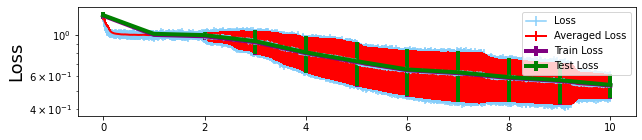

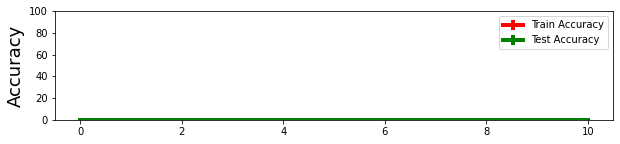

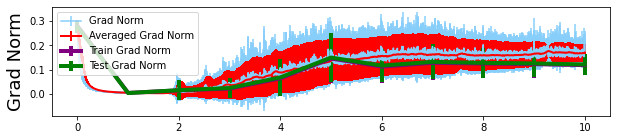

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=10, reset_error=True)
run_or_load(params)

Average total time: 0.05 h Final objective: 0.5163689 Final gradient norm: 0.13473496 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


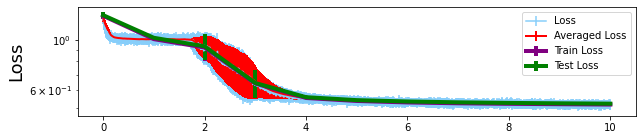

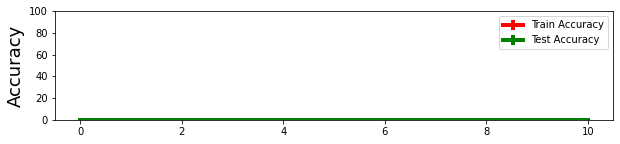

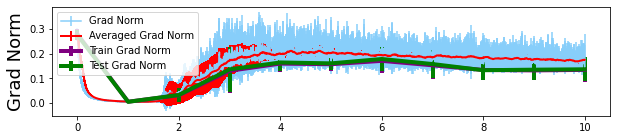

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=NoCompressorFactory(), epochs=10, reset_error=True)
run_or_load(params)

Average total time: 0.05 h Final objective: 0.5070436 Final gradient norm: 0.14519596 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


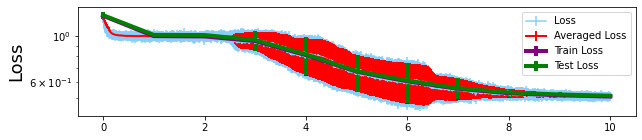

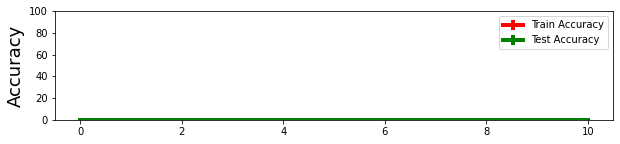

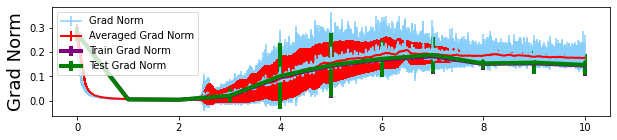

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory(), epochs=10, reset_error=True)
run_or_load(params)

Average total time: 0.05 h Final objective: 0.5148081 Final gradient norm: 0.16326602 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


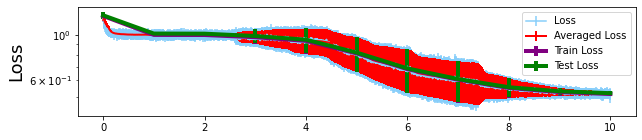

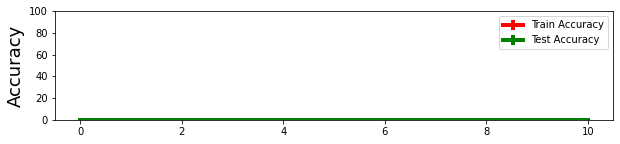

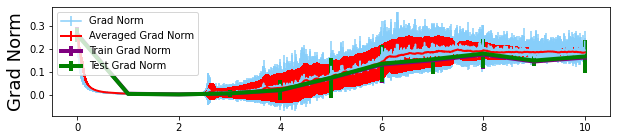

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=NoCompressorFactory(), epochs=10, reset_error=True)
run_or_load(params)

Average total time: 0.05 h Final objective: 0.5829698 Final gradient norm: 0.07843126 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


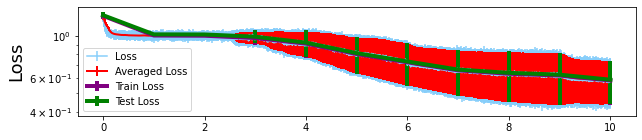

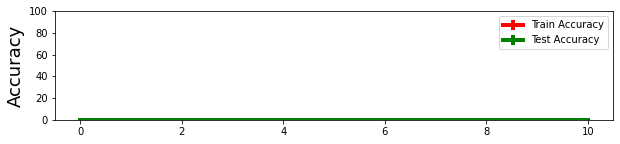

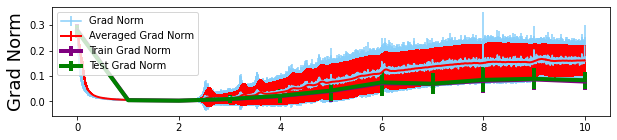

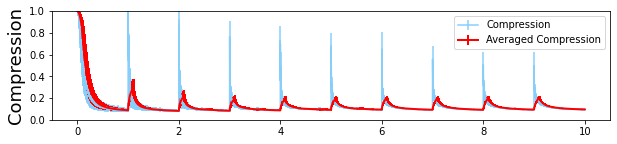

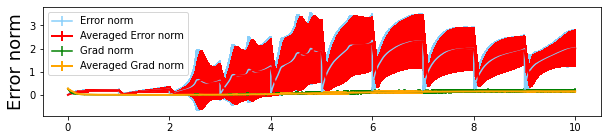

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=True)
run_or_load(params)

Average total time: 0.05 h Final objective: 0.5282219 Final gradient norm: 0.0873725 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


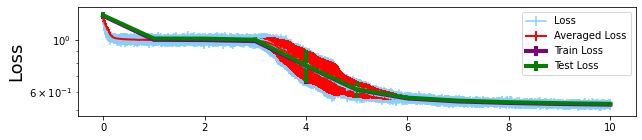

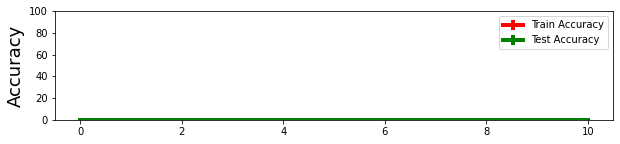

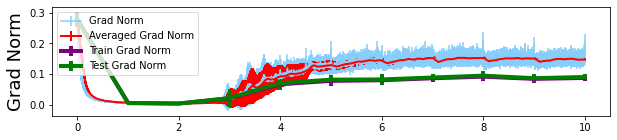

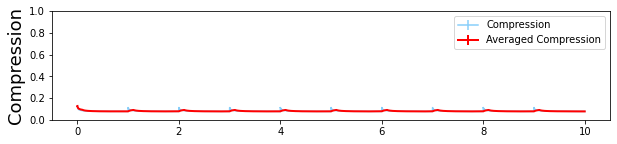

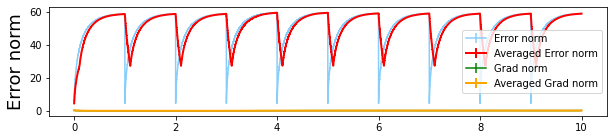

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=True)
run_or_load(params)

Average total time: 0.05 h Final objective: 0.55577004 Final gradient norm: 0.0635 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


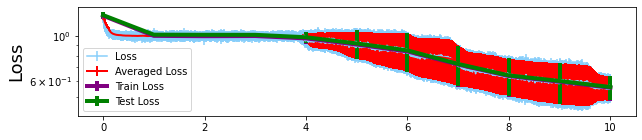

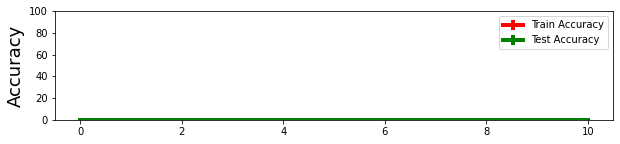

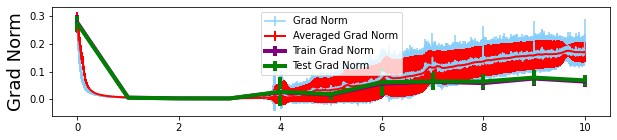

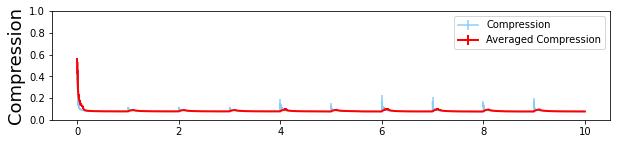

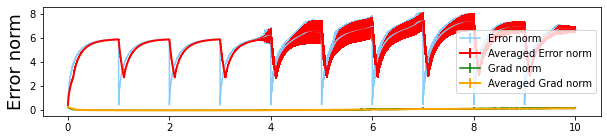

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=True)
run_or_load(params)

Average total time: 0.05 h Final objective: 0.562816 Final gradient norm: 0.08721544 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


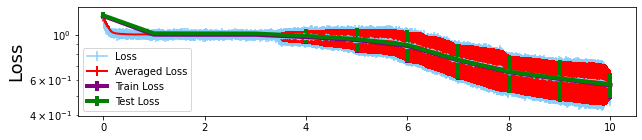

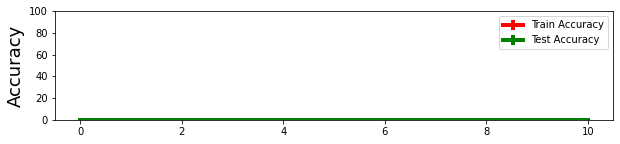

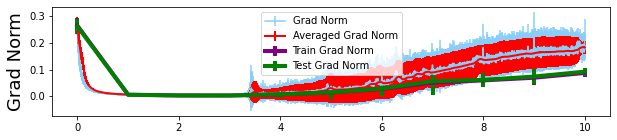

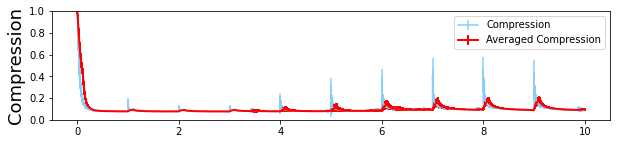

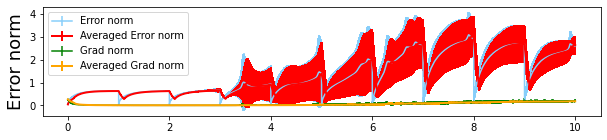

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=True)
run_or_load(params)

Average total time: 0.31 h Final objective: 0.83898544 Final gradient norm: 0.039408036 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


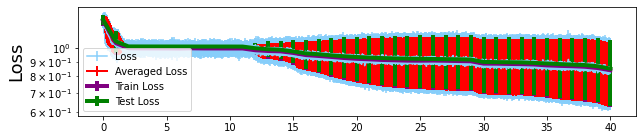

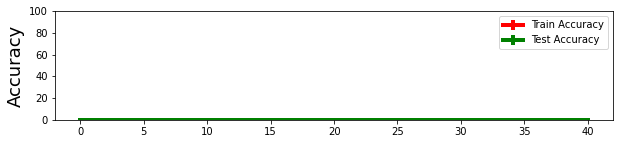

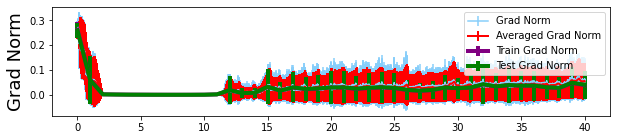

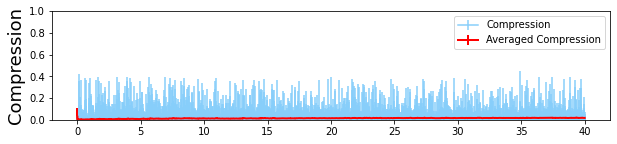

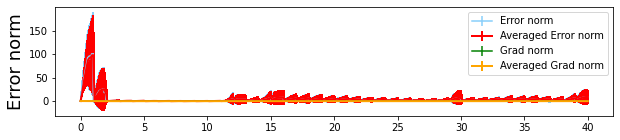

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.001), epochs=40, reset_error=True)
run_or_load(params)

Average total time: 0.32 h Final objective: 0.7902054 Final gradient norm: 0.061537065 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


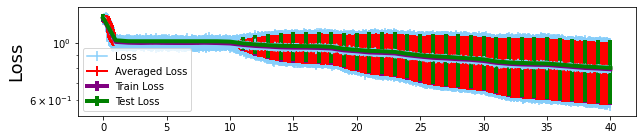

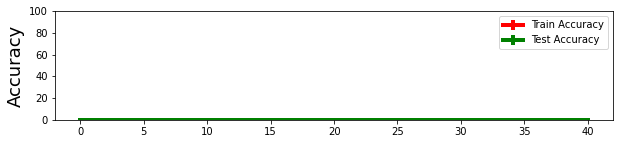

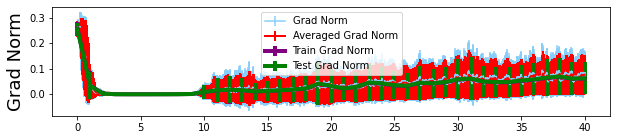

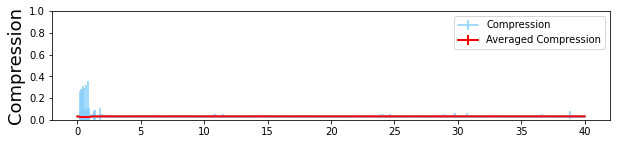

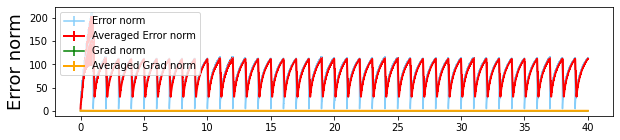

In [ ]:
params = tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.001), epochs=40, reset_error=True)
run_or_load(params)

### Uncompressed

Total time: 0.31 h Final objective: 1.5418346 Final gradient norm: 0.10936575 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


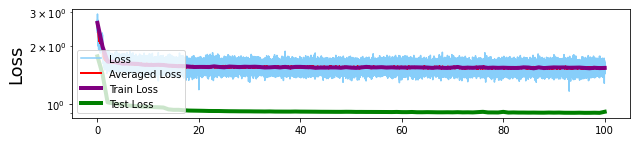

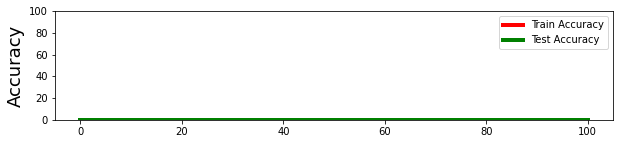

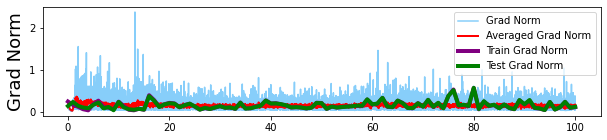

In [ ]:
params = tune_params(cifar_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory())
run_or_load(params) 

Total time: 0.32 h Final objective: 1.5443453 Final gradient norm: 0.17042589 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


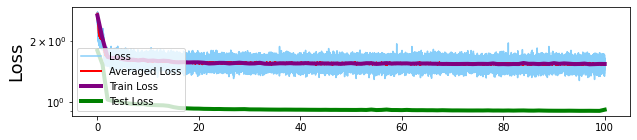

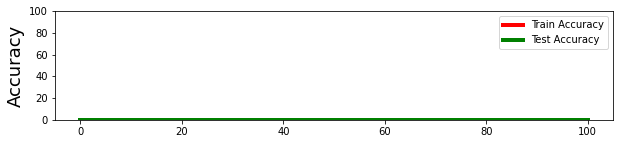

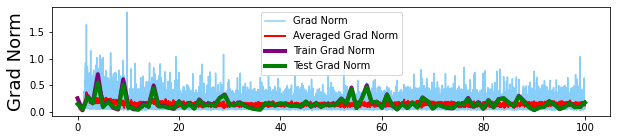

In [ ]:
params = tune_params(cifar_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory())
run_or_load(params)

## MNIST Autoencoder no BN

In [ ]:
mnist_autoencoder_nobn_params = Parameters(
    dataset=MnistDataset(),
    model_f=MnistAutoencoder(),
    batch_normalization=False,
    optimizer_parameters=OptimizerParameters(learning_rate=0.1, epochs=100, noise=None, weight_decay=0),
    evaluator=AutoencoderEvaluator(),
    compressor_f=None,
)

NameError: ignored

### Uncompressed

Total time: 0.48 h Final objective: 0.47294602 Final gradient norm: 0.056316867 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


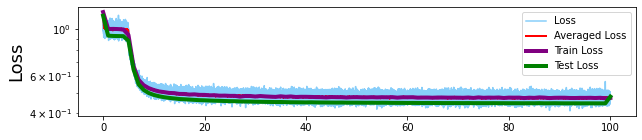

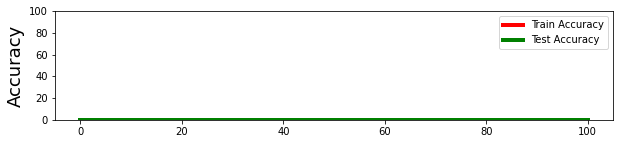

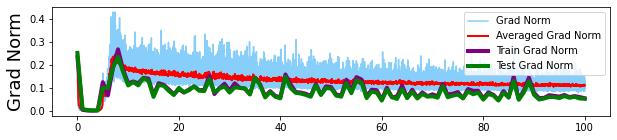

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory())
run_or_load(params)

Total time: 1.51 h Final objective: 0.4700486 Final gradient norm: 0.029897308 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


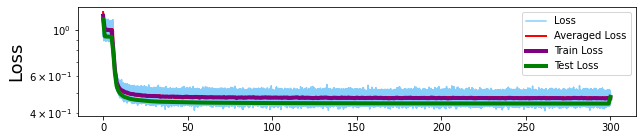

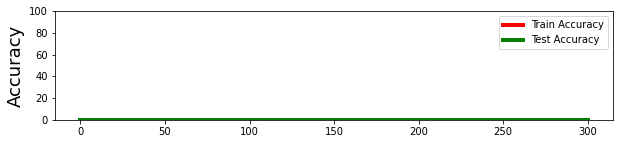

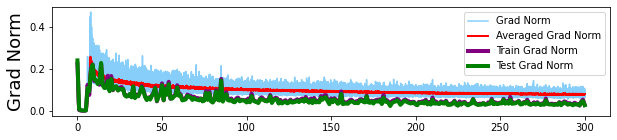

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=300)
run_or_load(params)

Total time: 0.27 h Final objective: 0.5048306 Final gradient norm: 0.28961113 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


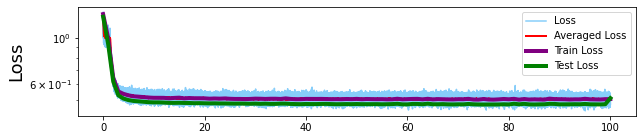

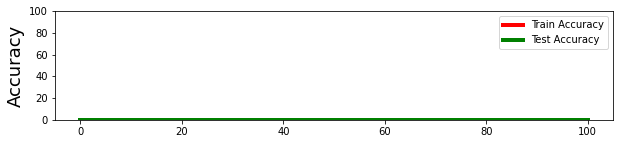

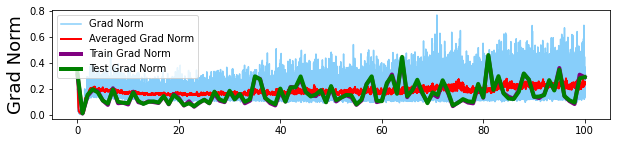

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=NoCompressorFactory())
run_or_load(params)

Total time: 0.40 h Final objective: 0.47417897 Final gradient norm: 0.06041793 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


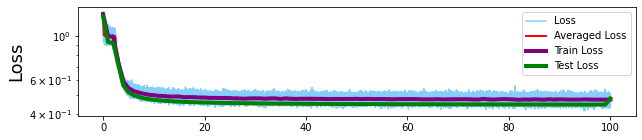

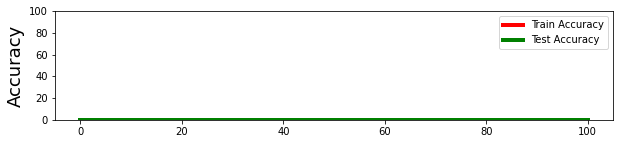

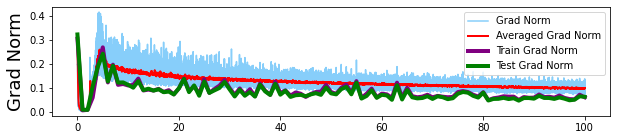

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory())
run_or_load(params)

Total time: 1.26 h Final objective: 0.47183108 Final gradient norm: 0.027701212 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


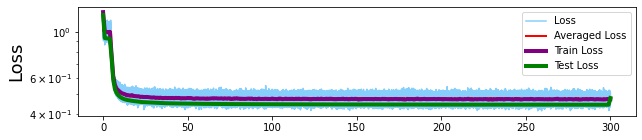

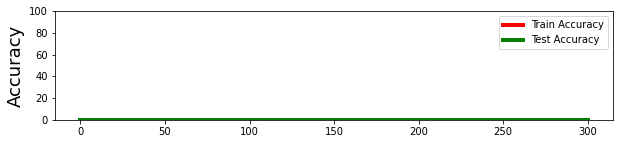

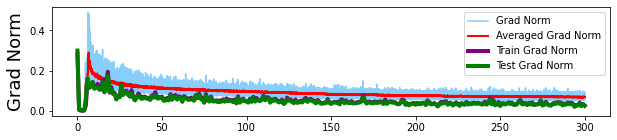

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory(), epochs=300)
run_or_load(params)

Total time: 0.52 h Final objective: 0.4727523 Final gradient norm: 0.053247675 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


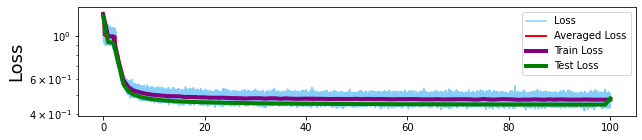

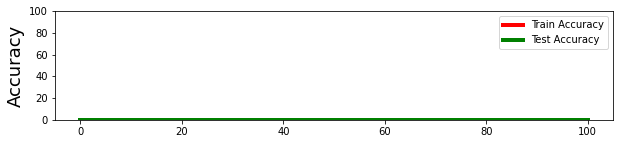

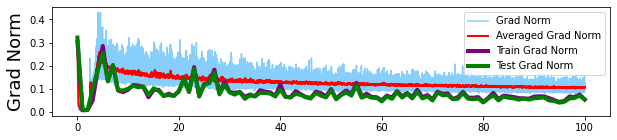

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=NoCompressorFactory())
run_or_load(params)

Total time: 1.63 h Final objective: 0.4703315 Final gradient norm: 0.095733166 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


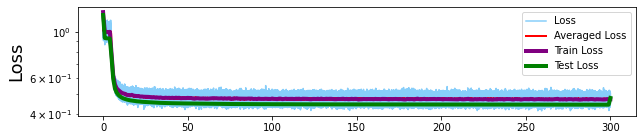

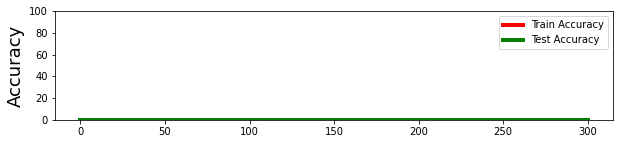

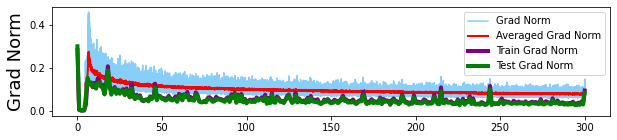

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=NoCompressorFactory(), epochs=300)
run_or_load(params)

### Few iterations

Total time: 0.10 h Final objective: 0.48623872 Final gradient norm: 0.10853741 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


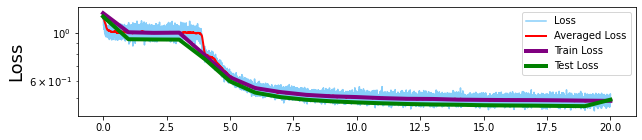

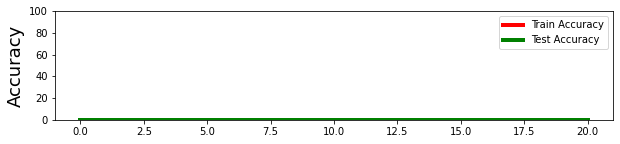

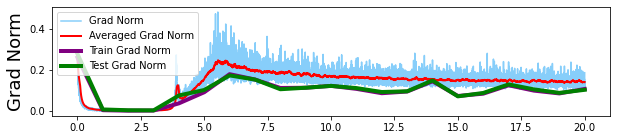

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=20)
run_or_load(params)

Total time: 0.11 h Final objective: 0.488813 Final gradient norm: 0.072194375 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


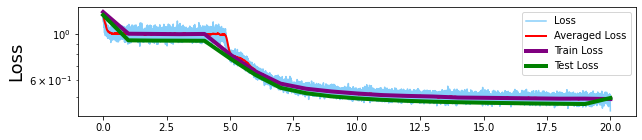

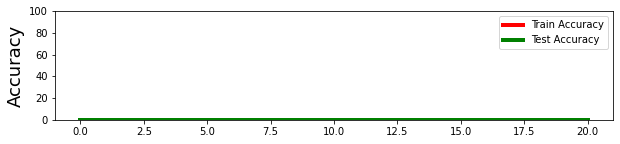

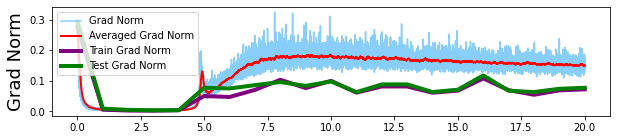

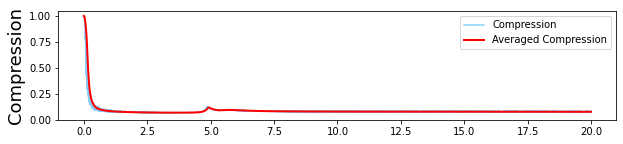

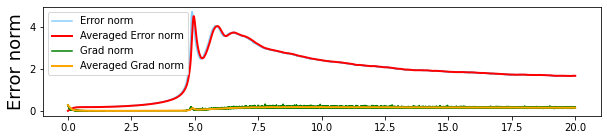

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.001), epochs=20)
run_or_load(params)

Total time: 0.11 h Final objective: 1.0000508 Final gradient norm: 8.203437e-12 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


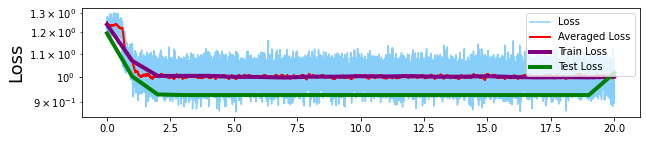

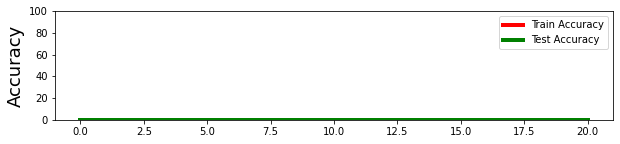

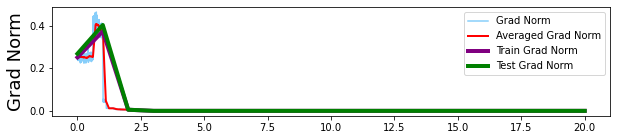

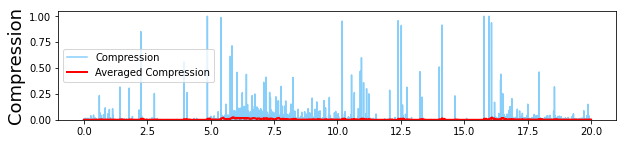

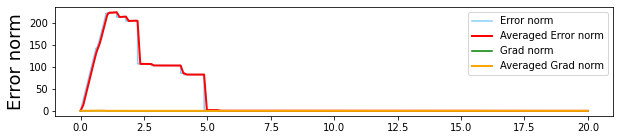

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.001), epochs=20)
run_or_load(params)

Total time: 0.10 h Final objective: 0.48800248 Final gradient norm: 0.064886115 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


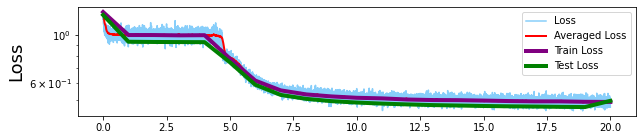

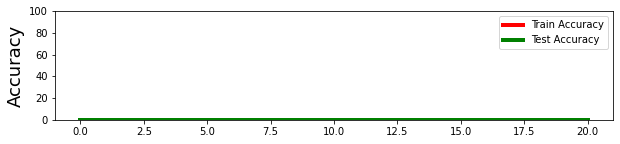

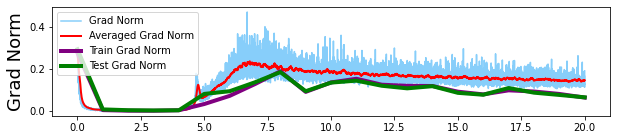

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory(), epochs=20)
run_or_load(params)

Total time: 0.11 h Final objective: 0.4900748 Final gradient norm: 0.055913202 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


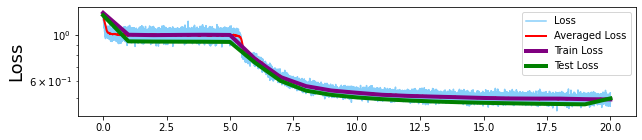

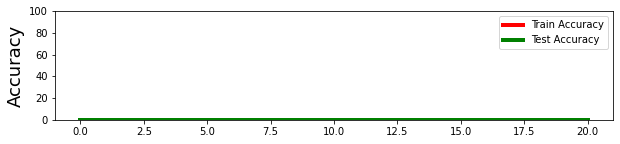

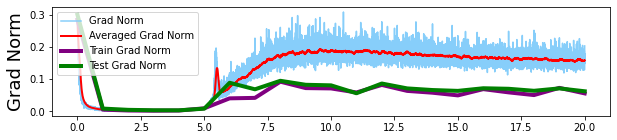

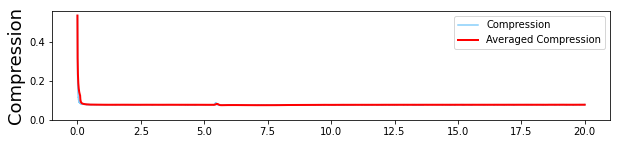

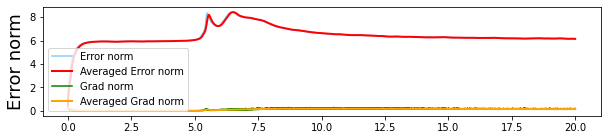

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=TopKCompressorFactory(0.001), epochs=20)
run_or_load(params)

Total time: 0.11 h Final objective: 1.0000508 Final gradient norm: 1.8974964e-09 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


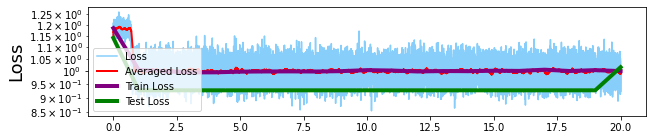

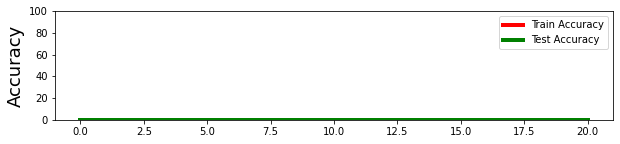

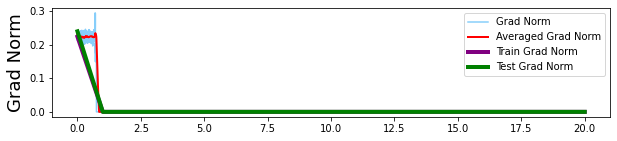

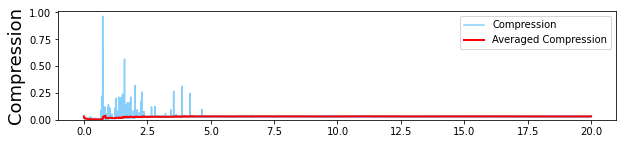

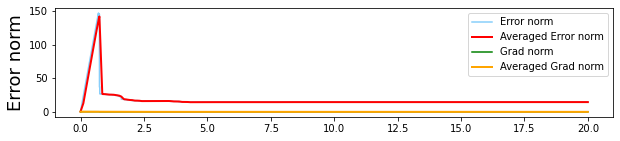

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=RandomCompressorFactory(0.001), epochs=20)
run_or_load(params)

## CIFAR no BN

In [ ]:
cifar_resnet_nobn_params = Parameters(
    dataset=CifarDataset(),
    model_f=ResNet34(),
    batch_normalization=False,
    optimizer_parameters=OptimizerParameters(learning_rate=0.1, epochs=100, noise=None, weight_decay=0),
    evaluator=ClassifierEvaluator(),
    compressor_f=None,
)

### Uncompressed

Total time: 1.08 h Final objective: 0.011612041 Final gradient norm: 0.09156864 Final Train Accuracy: 99.628 Final Test Accuracy: 90.73


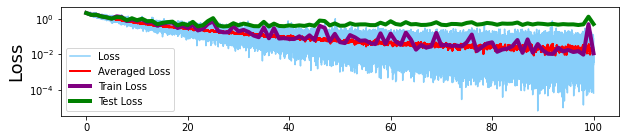

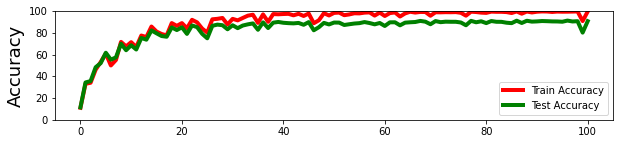

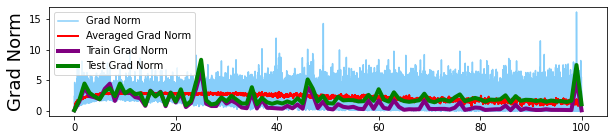

In [ ]:
params = tune_params(cifar_resnet_nobn_params, noise=0, compressor_f=NoCompressorFactory())
run_or_load(params)

## CIFAR BN

In [ ]:
cifar_resnet_bn_params = Parameters(
    dataset=CifarDataset(),
    model_f=ResNet34(),
    batch_normalization=True,
    optimizer_parameters=OptimizerParameters(learning_rate=0.1, epochs=100, noise=None, weight_decay=0),
    evaluator=ClassifierEvaluator(),
    compressor_f=None,
)

### Uncompressed

Total time: 1.52 h Final objective: 0.010648968 Final gradient norm: 0.08883023 Final Train Accuracy: 99.65 Final Test Accuracy: 90.6


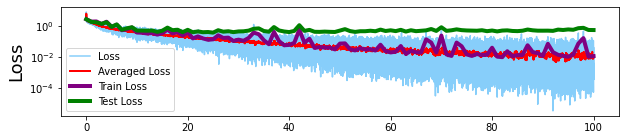

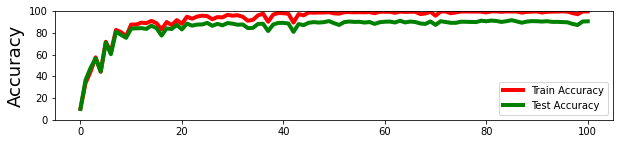

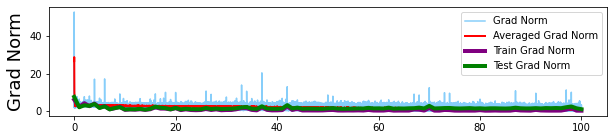

In [ ]:
params = tune_params(cifar_resnet_bn_params, noise=0, compressor_f=NoCompressorFactory())
run_or_load(params)

# New results

In [ ]:
# git("pull")

remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 12 (delta 6), reused 12 (delta 6), pack-reused 0
Unpacking objects: 100% (12/12), done.
From https://github.com/mlexperimentsgithubCompression/compression
   84ccfc5..2af69d2  master     -> origin/master
Updating 84ccfc5..2af69d2
Fast-forward
 .../compressions.npy                                | Bin 37648 -> 37648 bytes
 .../error_norms.npy                                 | Bin 37648 -> 37648 bytes
 .../grad_norms.npy                                  | Bin 37648 -> 37648 bytes
 .../losses.npy                                      | Bin 37648 -> 37648 bytes
 .../test_grad_norms.npy                             | Bin 172 -> 172 bytes
 .../test_losses.npy                                 | Bin 172 -> 172 bytes
 .../times.npy                                       | Bin 37648 -> 37648 bytes
 .../train_grad_norms.npy                            | Bin 

Total time: 0.07 h Final objective: 0.50630075 Final gradient norm: 0.09526646 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


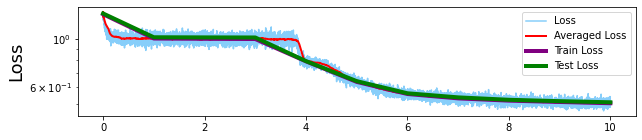

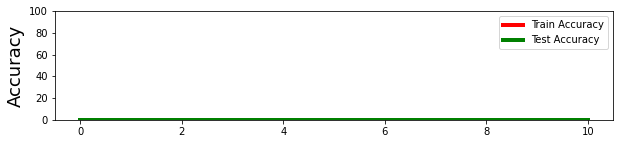

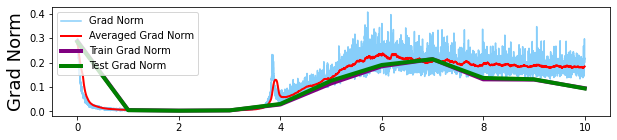

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)
run_or_load(params)

Total time: 0.03 h Final objective: 0.49962294 Final gradient norm: 0.10736464 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


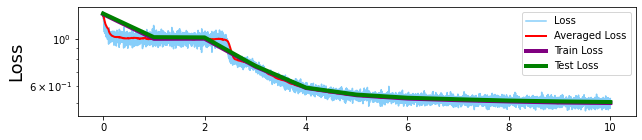

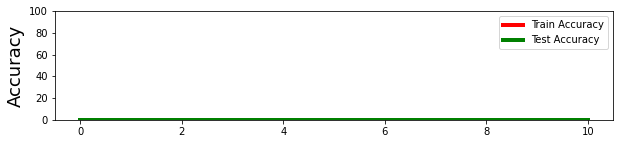

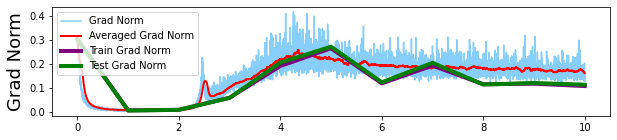

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)
run_or_load(params)

Total time: 0.03 h Final objective: 0.5168348 Final gradient norm: 0.13621895 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


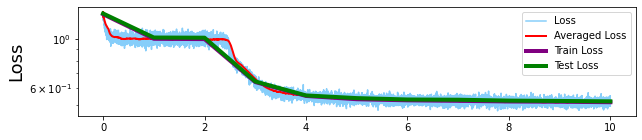

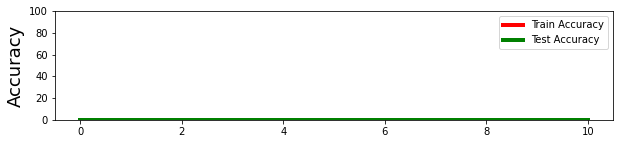

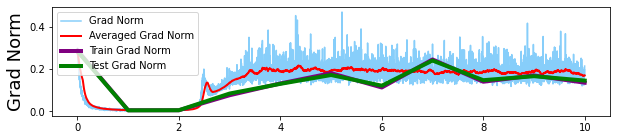

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)
run_or_load(params)

Total time: 0.08 h Final objective: 0.60001874 Final gradient norm: 0.060700513 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


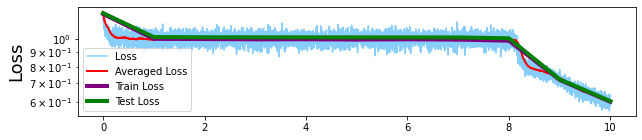

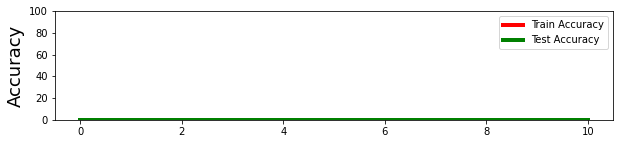

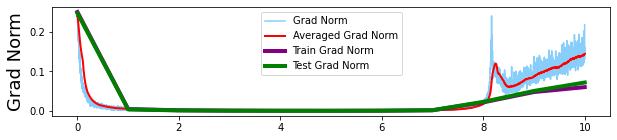

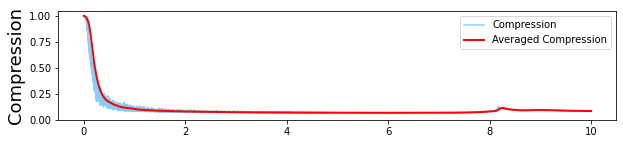

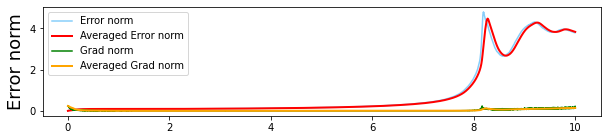

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=False, eigen_epochs=0)
run_or_load(params)

Total time: 0.05 h Final objective: 0.50894606 Final gradient norm: 0.050021976 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


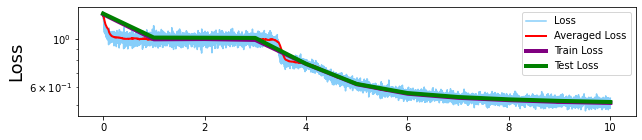

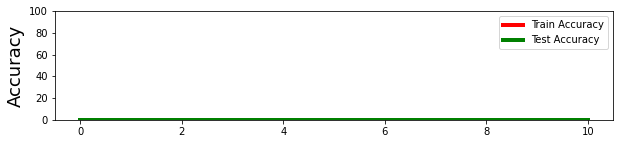

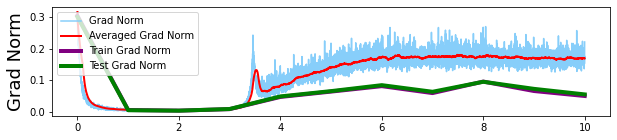

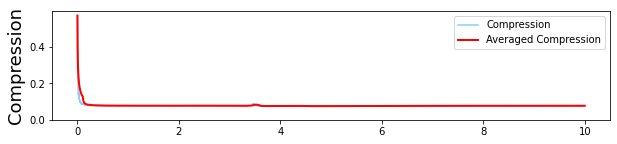

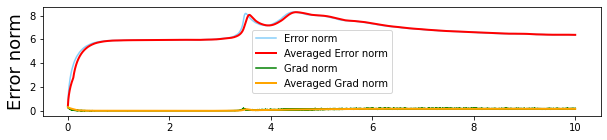

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=False, eigen_epochs=0)
run_or_load(params)

Total time: 0.21 h Final objective: 1.0000508 Final gradient norm: 7.296764e-18 Final Train Accuracy: 0.0 Final Test Accuracy: 0.0


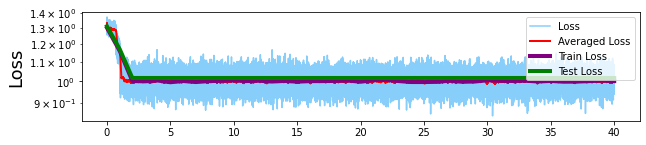

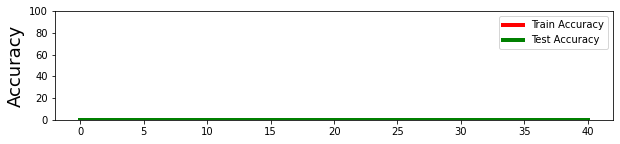

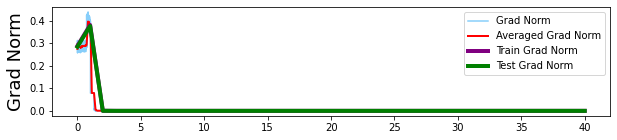

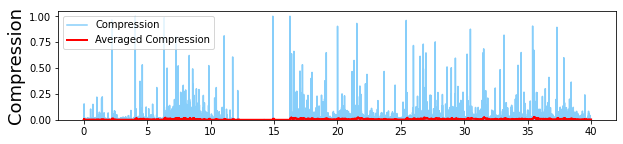

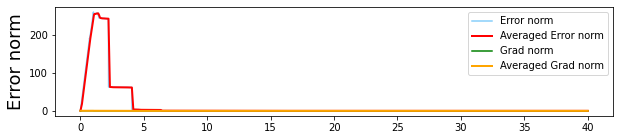

In [ ]:
params = tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.001), epochs=40, reset_error=False, eigen_epochs=0)
run_or_load(params)

# Comparisons

In [ ]:
compare_stat("topk",
             [get(tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=False, eigen_epochs=0)),
              get(tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=False, eigen_epochs=0))],
             ["Without noise", "With noise"])

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


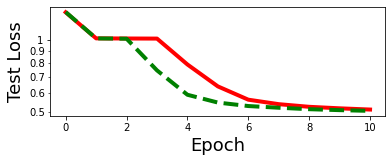

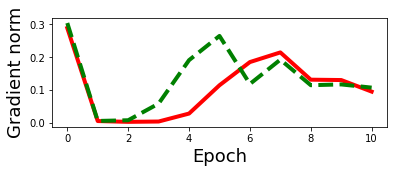

<Figure size 720x36 with 0 Axes>

In [ ]:
compare_stat("nocompr",
             [get(tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)),
              get(tune_params(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0))],
             ["Without noise", "With noise"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


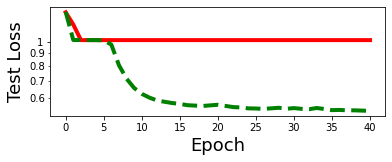

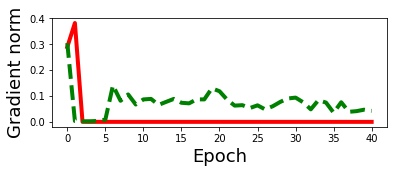

<Figure size 720x36 with 0 Axes>

In [ ]:
compare_stat("random",
             [get(tune_params(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.001), epochs=40, reset_error=False, eigen_epochs=0)),
              get(tune_params(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.001), epochs=40, reset_error=False, eigen_epochs=0))],
             ["Without noise", "With noise"])

# New comparisons

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


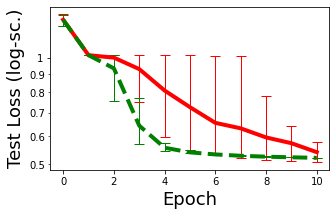

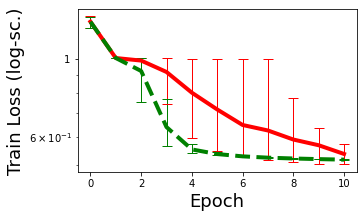

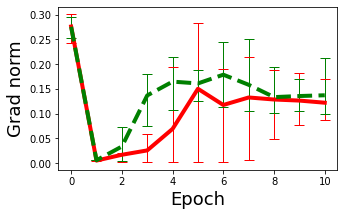

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("nocompr",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0))],
             ["Without noise", "With noise"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


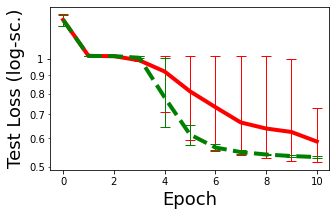

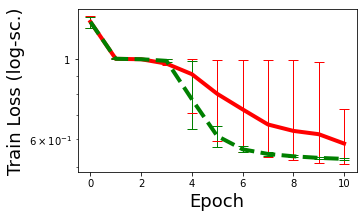

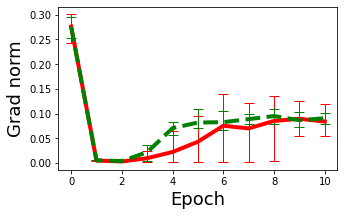

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("topk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=TopKCompressorFactory(0.001), epochs=10, reset_error=False, eigen_epochs=0))],
             ["Without noise", "With noise"])

In [ ]:
# compare_stat("random",
#              [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.001), epochs=40, reset_error=False, eigen_epochs=0)),
#               get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.001), epochs=40, reset_error=False, eigen_epochs=0))],
#              ["Without noise", "With noise"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


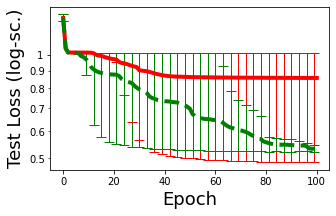

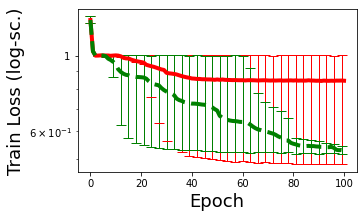

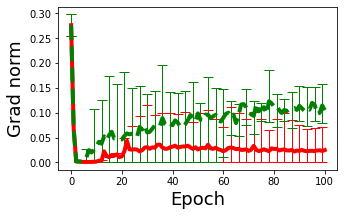

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("random",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.001), epochs=100, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.001), epochs=100, reset_error=False, eigen_epochs=0))],
             ["Without noise", "With noise"])

# Comparisons with avg grad

In [ ]:
git("pull")

Already up to date.


In [ ]:
mnist_autoencoder_nobn_params = Args(
    dataset=MnistDataset(),
    model_f=MnistAutoencoder(),
    batch_normalization=False,
    optimizer_args=OptimizerArgs(learning_rate=0.1, epochs=None, noise=None, weight_decay=0),
    evaluator=AutoencoderEvaluator(),
    compressor_f=None,
    reset_error=None,
    eigen_epochs=0,
    n_runs=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


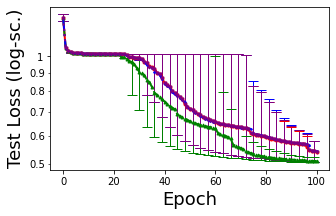

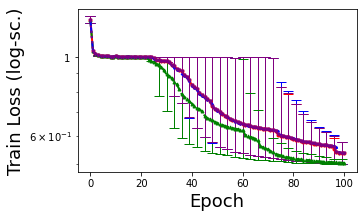

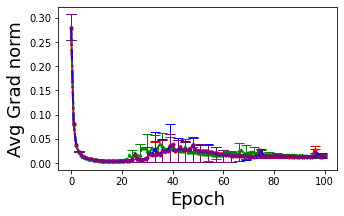

<Figure size 864x36 with 0 Axes>

In [ ]:
compare_stat("nocompr",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=100, reset_error=False, eigen_epochs=0, learning_rate=0.01)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=NoCompressorFactory(), epochs=100, reset_error=False, eigen_epochs=0, learning_rate=0.01)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory(), epochs=100, reset_error=False, eigen_epochs=0, learning_rate=0.01)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=NoCompressorFactory(), epochs=100, reset_error=False, eigen_epochs=0, learning_rate=0.01)),
              ],
             ["$\sigma = 0$", "$\sigma = \sqrt{d} \cdot 0.01$", "$\sigma = \sqrt{d} \cdot 0.001$", "$\sigma = \sqrt{d} \cdot 0.0001$"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


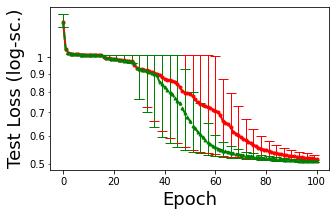

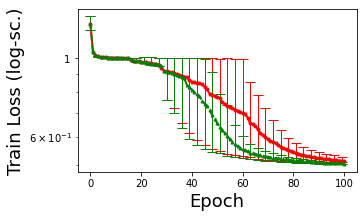

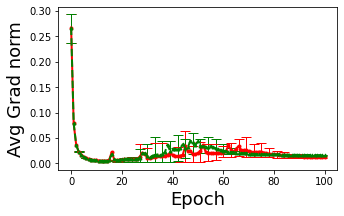

<Figure size 864x36 with 0 Axes>

In [ ]:
compare_stat("topk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.01), epochs=100, reset_error=True, eigen_epochs=0, learning_rate=0.01)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=TopKCompressorFactory(0.01), epochs=100, reset_error=True, eigen_epochs=0, learning_rate=0.01)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=TopKCompressorFactory(0.01), epochs=100, reset_error=True, eigen_epochs=0, learning_rate=0.01)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=TopKCompressorFactory(0.01), epochs=100, reset_error=True, eigen_epochs=0, learning_rate=0.01)),
              ],
             ["$\sigma = 0$", "$\sigma = \sqrt{d} \cdot 0.01$", "$\sigma = \sqrt{d} \cdot 0.001$", "$\sigma = \sqrt{d} \cdot 0.0001$"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


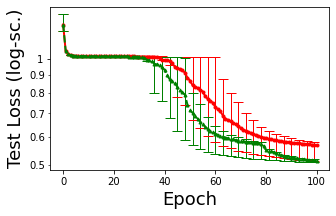

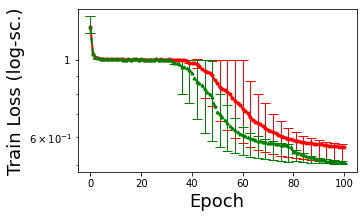

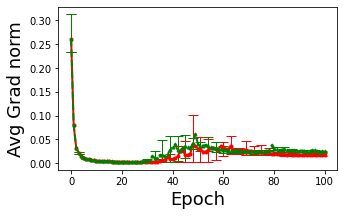

<Figure size 864x36 with 0 Axes>

In [ ]:
compare_stat("randomk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.01), epochs=100, reset_error=False, eigen_epochs=0, learning_rate=0.01)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.01), epochs=100, reset_error=False, eigen_epochs=0, learning_rate=0.01)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=RandomCompressorFactory(0.01), epochs=100, reset_error=False, eigen_epochs=0, learning_rate=0.01)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=RandomCompressorFactory(0.01), epochs=100, reset_error=False, eigen_epochs=0, learning_rate=0.01)),
              ],
             ["$\sigma = 0$", "$\sigma = \sqrt{d} \cdot 0.01$", "$\sigma = \sqrt{d} \cdot 0.001$", "$\sigma = \sqrt{d} \cdot 0.0001$"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


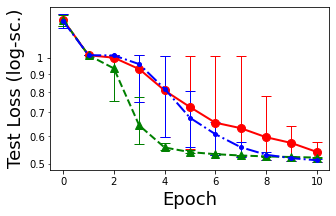

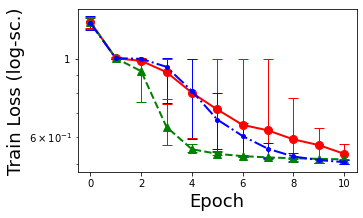

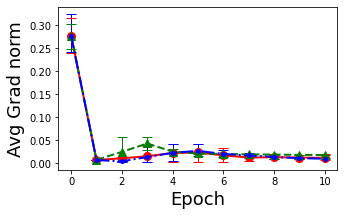

<Figure size 864x36 with 0 Axes>

In [ ]:
compare_stat("nocompr",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=NoCompressorFactory(), epochs=10, reset_error=False, eigen_epochs=0)),
              ],
             ["$\sigma = 0$", "$\sigma = \sqrt{d} \cdot 0.01$", "$\sigma = \sqrt{d} \cdot 0.001$", "$\sigma = \sqrt{d} \cdot 0.0001$"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


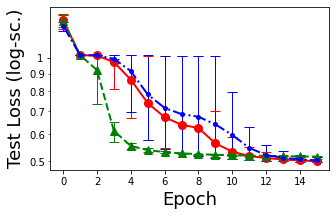

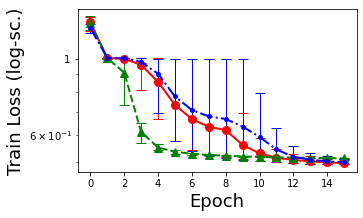

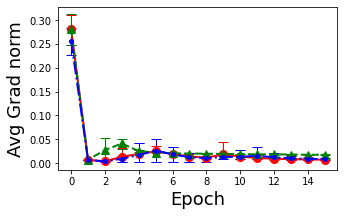

<Figure size 864x36 with 0 Axes>

In [ ]:
compare_stat("topk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.01), epochs=15, reset_error=True, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=TopKCompressorFactory(0.01), epochs=15, reset_error=True, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=TopKCompressorFactory(0.01), epochs=15, reset_error=True, eigen_epochs=0)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=TopKCompressorFactory(0.01), epochs=15, reset_error=True, eigen_epochs=0)),
              ],
             ["$\sigma = 0$", "$\sigma = \sqrt{d} \cdot 0.01$", "$\sigma = \sqrt{d} \cdot 0.001$", "$\sigma = \sqrt{d} \cdot 0.0001$"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


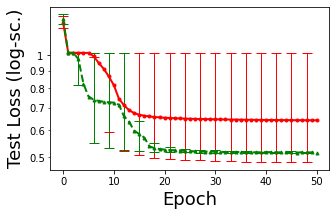

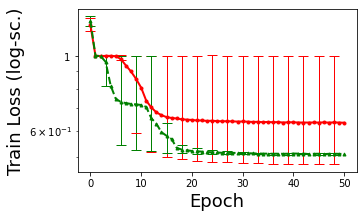

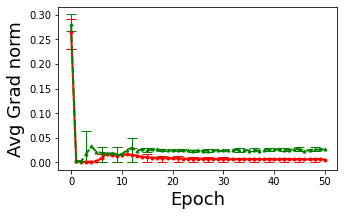

<Figure size 864x36 with 0 Axes>

In [ ]:
compare_stat("randomk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.01), epochs=50, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.01), epochs=50, reset_error=False, eigen_epochs=0)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=RandomCompressorFactory(0.01), epochs=50, reset_error=False, eigen_epochs=0)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=RandomCompressorFactory(0.01), epochs=50, reset_error=False, eigen_epochs=0)),
              ],
             ["$\sigma = 0$", "$\sigma = \sqrt{d} \cdot 0.01$", "$\sigma = \sqrt{d} \cdot 0.001$", "$\sigma = \sqrt{d} \cdot 0.0001$"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


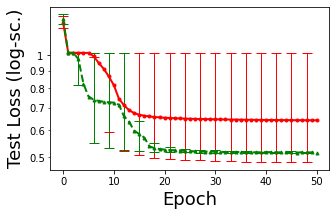

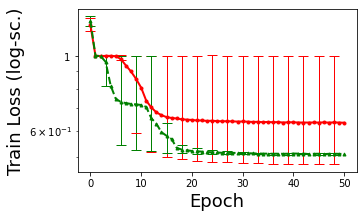

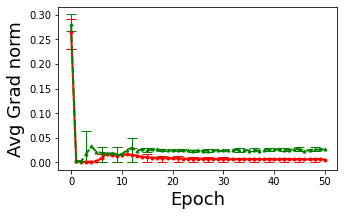

<Figure size 864x36 with 0 Axes>

In [ ]:
compare_stat("randomk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.01), epochs=50, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.01), epochs=50, reset_error=False, eigen_epochs=0)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.001, compressor_f=RandomCompressorFactory(0.01), epochs=50, reset_error=False, eigen_epochs=0)),
              # get(tune_args(mnist_autoencoder_nobn_params, noise=0.0001, compressor_f=RandomCompressorFactory(0.01), epochs=50, reset_error=False, eigen_epochs=0)),
              ],
             ["$\sigma = 0$", "$\sigma = \sqrt{d} \cdot 0.01$", "$\sigma = \sqrt{d} \cdot 0.001$", "$\sigma = \sqrt{d} \cdot 0.0001$"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


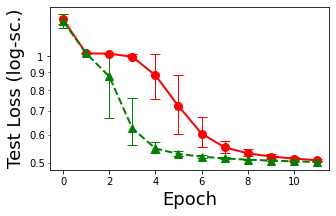

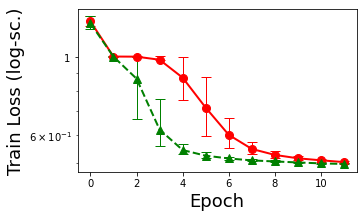

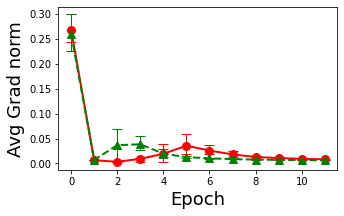

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("nocompr",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=11, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=NoCompressorFactory(), epochs=11, reset_error=False, eigen_epochs=0))
              ],
             ["Without noise", "With noise"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


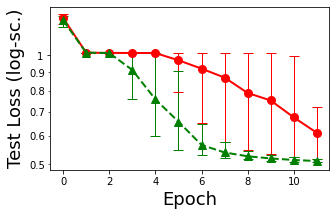

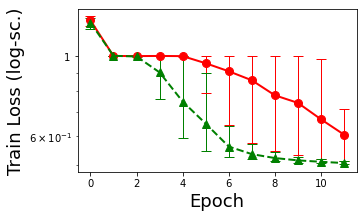

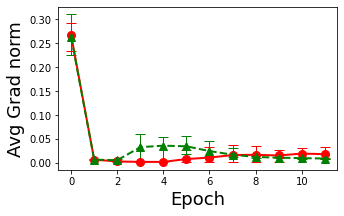

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("topk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.001), epochs=11, reset_error=True, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=TopKCompressorFactory(0.001), epochs=11, reset_error=True, eigen_epochs=0))
              ],
             ["Without noise", "With noise"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


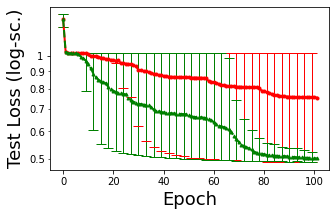

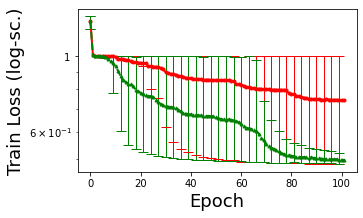

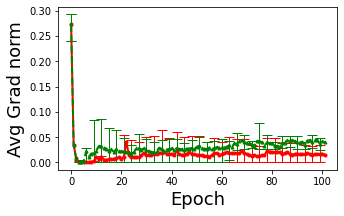

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("randomk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.001), epochs=101, reset_error=True)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.001), epochs=101, reset_error=True))
              ],
             ["Without noise", "With noise"])

# Comparisons with var step size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


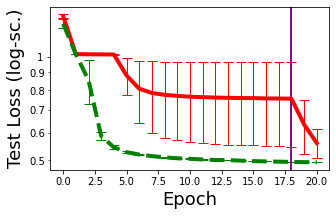

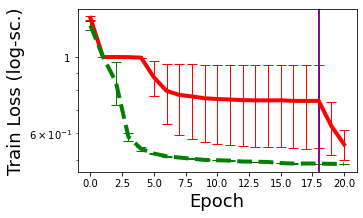

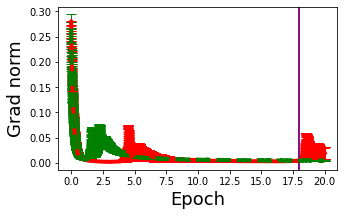

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("nocompr",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=NoCompressorFactory(), epochs=20, reset_error=False, eigen_epochs=0, n_runs=2)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=NoCompressorFactory(), epochs=20, reset_error=False, eigen_epochs=0, n_runs=2))
              ],
             ["Without noise", "With noise"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


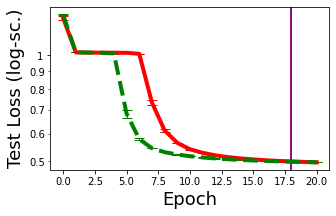

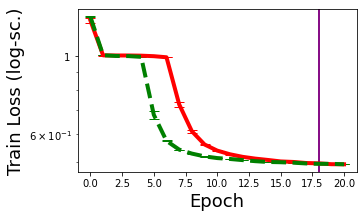

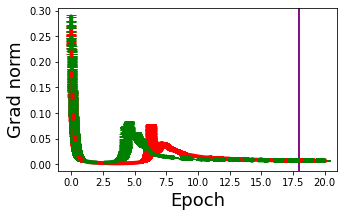

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("topk",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=TopKCompressorFactory(0.001), epochs=20, reset_error=True, eigen_epochs=0, n_runs=2)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=TopKCompressorFactory(0.001), epochs=20, reset_error=True, eigen_epochs=0, n_runs=2))],
             ["Without noise", "With noise"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


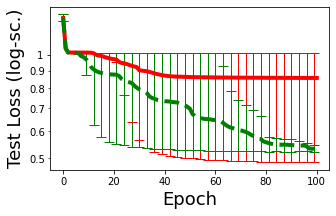

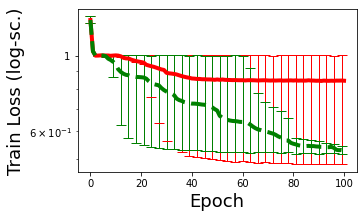

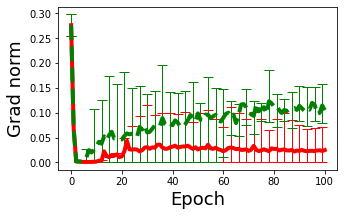

<Figure size 648x36 with 0 Axes>

In [ ]:
compare_stat("random",
             [get(tune_args(mnist_autoencoder_nobn_params, noise=0, compressor_f=RandomCompressorFactory(0.001), epochs=100, reset_error=False, eigen_epochs=0)),
              get(tune_args(mnist_autoencoder_nobn_params, noise=0.01, compressor_f=RandomCompressorFactory(0.001), epochs=100, reset_error=False, eigen_epochs=0))],
             ["Without noise", "With noise"])

In [ ]:
if True:
  !zip -r plots.zip plots
  files.download("plots.zip")

updating: plots/ (stored 0%)
updating: plots/topk_train_loss.pdf (deflated 35%)
updating: plots/randomk_train_loss.pdf (deflated 26%)
updating: plots/nocompr_train_loss.pdf (deflated 35%)
updating: plots/randomk_legend.pdf (deflated 37%)
updating: plots/topk_gradnorm.pdf (deflated 32%)
updating: plots/nocompr_loss.pdf (deflated 34%)
updating: plots/topk_legend.pdf (deflated 37%)
updating: plots/randomk_gradnorm.pdf (deflated 24%)
updating: plots/nocompr_legend.pdf (deflated 37%)
updating: plots/randomk_loss.pdf (deflated 25%)
updating: plots/nocompr_gradnorm.pdf (deflated 32%)
updating: plots/topk_loss.pdf (deflated 34%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>